#Cannabis Clustering
The main goal of this should be to compare the DBSCAN clustering algorithm (non-linear) to another clusering algorithm (e.g. K-means Clustering which is Linear).

1. Run the hidden cells in Part I & Part II. This will import and clean the data before performing dimensionality reduction. The PCA plot isn't great for visualization, but it tells us that the data is high-dimensional but linear (can be fully separated into 18 Principal Components-- AKA 18-Dimensional but linear). For the most part, I used the UMAP reduction for plotting. You can plot things by calling *sns.scatter()* and set: 



> **x=clean_lowD_60[:, 0]**

>**y=clean_lowD_60[:, 1]**.

2. Run DBSCAN with the parameters kept as they are. These are the parameters we used for our clustering with DBSCAN, so you should be able to compare the results you got with linear clustering (k-means) to these clusters.
3. Run the linear clustering algorithm. 

4. Once you have the clusters with different values for the linear clustering algorithm's hyperparmaters, you can compare the clusters based on extant data on cannabis types (happy to talk more about this with you).


In [1]:
#@title Load in Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
#import gspread
#from gspread_dataframe import get_as_dataframe, set_with_dataframe 

# Plotting settings
# In case the font Cambria is not locally installed in you system, 
# comment out the line below
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = 10,6

In [2]:
#@title Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

#Part I: Import the Data

In this first chunk of code, we write a dataframe from the data csv found on github. Once this has been loaded, we remove any columns not needed for this analysis.

We next normalize the cannabinoid and terpene data separately. To do this, we divide each set by the value of its largest element. As a result, we are left with a data entry comprised of a *strain name*, *region*, *cannabinoid profile*, and *terpene profile*.

Lastly, some of the entries are missing data. Since the data set is so large, we drop entries with missing data.

Once we have this cleaned data set, it can be further separated into smaller data sets based on where each strain was grown. Using this method, we create four regional sub-sets. This gives us:

1. **clean_data** (Full data set)
2. **AK_data** (Arkansas data set)
3. **OR_data** (Oregon data set)
4. **WA_data** (Washington data set)
5. **CA_data** (California data set)

Each of these data sets is now ready to be reduced to a lower dimensional space using PCA or UMAP in (Part II). **{Ready}**

In Part III, we'll use a clustering algorithm like DBSCAN to categorize cannabis based on the results in Part II. **{Read minus plots}**

In Part IV, we'll generate a data set that includes cluster membership for each entry. This data set will be randomly split into a test set and a training set.**{Ready}**

In Part V, we'll train a LASSO regression model on the training data until it can accurately assign categories for each entry.

In Part VI, we'll test the LASSO regression model on the test set and get the classification error rate.
 
Depending on our success here, we can move onto an optional Part VII where we classify strains not originally in the data set using freely available COAs.

In [3]:
#@title Load in data as CSV
data_url = "https://raw.githubusercontent.com/cjsmith015/phytochemical-diversity-cannabis/main/data/preproc_lab_data_pub_20220218.csv"
raw_data = pd.read_csv(data_url, index_col=0)
selected_data = raw_data.drop(columns = ['lab_id', 'anon_producer', 'product_category', 'strain_category', 
                              'strain_popularity', 'chemotype', 'has_cannabs', 'has_terps', 'terp_var',
                              'chemotype_ratio','total_terps', 'top_terp_f'])
selected_data.head()

strain_slug region    tot_thc   tot_cbd   tot_cbg   tot_cbc  tot_cbn  \
u_id                                                                        
0            NaN     AK  20.103098  0.047210  1.097430  0.000000      0.0   
1            NaN     AK  17.775078  0.085711  0.904467  0.046734      0.0   
2            NaN     AK  18.196924  0.079075  0.923358  0.056123      0.0   
3            NaN     AK  19.302718  0.059964  0.517679  0.034465      0.0   
4            NaN     AK  18.224250  0.071973  0.966903  0.000000      0.0   

      tot_thcv  tot_ocimene  camphene  ...  humulene  caryophyllene  limonene  \
u_id                                   ...                                      
0     0.255775     0.251212      0.01  ...  0.217018       0.560682  0.159195   
1     0.050000     0.374661      0.01  ...  0.143383       0.315326  0.127196   
2     0.050000     0.334714      0.01  ...  0.140367       0.306051  0.111072   
3     0.050000     0.010000      0.01  ...  0.167629       0.385306  0.134872   
4     0.231606     0.158674      0.01  ...  0.127600       0.317787  0.116072   

      linalool   myrcene  bisabolol  b_pinene  a_terpinene  terpinolene  \
u_id                                                                      
0     0.032776  0.177072   0.029597  0.114252     0.010000     0.321310   
1     0.010000  0.199761   0.010000  0.069859     0.012731     0.365565   
2     0.022061  0.177568   0.010000  0.057884     0.011981     0.336826   
3     0.056048  0.368547   0.048849  0.035711     0.000000     0.000000   
4     0.029350  0.099418   0.010000  0.083642     0.010000     0.179980   

      a_pinene  
u_id            
0     0.075442  
1     0.060920  
2     0.049393  
3     0.020058  
4     0.056437  

[5 rows x 22 columns]

In [4]:
#@title Name Unnamed Samples
#"Sample_" + str(selected_data.index[0])
#print(selected_data.columns.tolist())

cell = selected_data.iloc[0,0]
np.isnan(cell)

for row in range(len(selected_data)):
  cell = selected_data.iloc[row,0]
  if pd.isna(cell) == True:
    selected_data.iloc[row,0] = "Sample_" + str(selected_data.index[row])

selected_data.head()

strain_slug region    tot_thc   tot_cbd   tot_cbg   tot_cbc  tot_cbn  \
u_id                                                                        
0       Sample_0     AK  20.103098  0.047210  1.097430  0.000000      0.0   
1       Sample_1     AK  17.775078  0.085711  0.904467  0.046734      0.0   
2       Sample_2     AK  18.196924  0.079075  0.923358  0.056123      0.0   
3       Sample_3     AK  19.302718  0.059964  0.517679  0.034465      0.0   
4       Sample_4     AK  18.224250  0.071973  0.966903  0.000000      0.0   

      tot_thcv  tot_ocimene  camphene  ...  humulene  caryophyllene  limonene  \
u_id                                   ...                                      
0     0.255775     0.251212      0.01  ...  0.217018       0.560682  0.159195   
1     0.050000     0.374661      0.01  ...  0.143383       0.315326  0.127196   
2     0.050000     0.334714      0.01  ...  0.140367       0.306051  0.111072   
3     0.050000     0.010000      0.01  ...  0.167629       0.385306  0.134872   
4     0.231606     0.158674      0.01  ...  0.127600       0.317787  0.116072   

      linalool   myrcene  bisabolol  b_pinene  a_terpinene  terpinolene  \
u_id                                                                      
0     0.032776  0.177072   0.029597  0.114252     0.010000     0.321310   
1     0.010000  0.199761   0.010000  0.069859     0.012731     0.365565   
2     0.022061  0.177568   0.010000  0.057884     0.011981     0.336826   
3     0.056048  0.368547   0.048849  0.035711     0.000000     0.000000   
4     0.029350  0.099418   0.010000  0.083642     0.010000     0.179980   

      a_pinene  
u_id            
0     0.075442  
1     0.060920  
2     0.049393  
3     0.020058  
4     0.056437  

[5 rows x 22 columns]

In [5]:
#@title Normalize Cannabinoids
CB_raw = selected_data.iloc[:, 2:8]
CB_norm = CB_raw
for row in range(len(CB_raw)):
  CB_norm.iloc[row] = CB_raw.iloc[row] / sum(CB_raw.iloc[row])
CB_norm.head()

tot_thc   tot_cbd   tot_cbg   tot_cbc  tot_cbn  tot_thcv
u_id                                                           
0     0.934875  0.002195  0.051035  0.000000      0.0  0.011895
1     0.942376  0.004544  0.047952  0.002478      0.0  0.002651
2     0.942578  0.004096  0.047829  0.002907      0.0  0.002590
3     0.966836  0.003003  0.025930  0.001726      0.0  0.002504
4     0.934829  0.003692  0.049598  0.000000      0.0  0.011880

In [6]:
#@title Normalize Terpenes
TP_raw = selected_data.iloc[:, 8:]
TP_norm = TP_raw
for row in range(len(TP_raw)):
  TP_norm.iloc[row] = TP_raw.iloc[row] / sum(TP_raw.iloc[row])

TP_norm.head()

tot_ocimene  camphene  g_terpinene  tot_nerolidol_ct  humulene  \
u_id                                                                   
0        0.126627  0.005041     0.007724          0.005041  0.109391   
1        0.215732  0.005758     0.008682          0.012792  0.082561   
2        0.208189  0.006220     0.008142          0.016626  0.087307   
3        0.008019  0.008019     0.008019          0.000000  0.134423   
4        0.129744  0.008177     0.011458          0.008177  0.104336   

      caryophyllene  limonene  linalool   myrcene  bisabolol  b_pinene  \
u_id                                                                     
0          0.282619  0.080244  0.016521  0.089255   0.014919  0.057590   
1          0.181566  0.073240  0.005758  0.115024   0.005758  0.040225   
2          0.190361  0.069086  0.013722  0.110446   0.006220  0.036003   
3          0.308981  0.108156  0.044945  0.295542   0.039173  0.028637   
4          0.259848  0.094910  0.023999  0.081292   0.008177  0.068392   

      a_terpinene  terpinolene  a_pinene  
u_id                                      
0        0.005041     0.161961  0.038028  
1        0.007331     0.210494  0.035078  
2        0.007452     0.209503  0.030722  
3        0.000000     0.000000  0.016085  
4        0.008177     0.147166  0.046147

In [7]:
#@title Recombine Normalized Data into Clean Data set
indentifiers = selected_data.iloc[:, 0:2]
clean_data = pd.concat([indentifiers, CB_norm, TP_norm], axis=1)
clean_data = clean_data.dropna()
clean_data

strain_slug region   tot_thc   tot_cbd   tot_cbg   tot_cbc  tot_cbn  \
u_id                                                                          
0          Sample_0     AK  0.934875  0.002195  0.051035  0.000000      0.0   
1          Sample_1     AK  0.942376  0.004544  0.047952  0.002478      0.0   
2          Sample_2     AK  0.942578  0.004096  0.047829  0.002907      0.0   
3          Sample_3     AK  0.966836  0.003003  0.025930  0.001726      0.0   
4          Sample_4     AK  0.934829  0.003692  0.049598  0.000000      0.0   
...             ...    ...       ...       ...       ...       ...      ...   
88943  Sample_88943     CA  0.938651  0.002171  0.059177  0.000000      0.0   
88944  Sample_88944     CA  0.950399  0.002075  0.047527  0.000000      0.0   
88980     gods-gift     CA  0.969916  0.002917  0.026502  0.000665      0.0   
88998      ghost-og     CA  0.970867  0.002627  0.026506  0.000000      0.0   
88999     butter-og     CA  0.968337  0.002012  0.029651  0.000000      0.0   

       tot_thcv  tot_ocimene  camphene  ...  humulene  caryophyllene  \
u_id                                    ...                            
0      0.011895     0.126627  0.005041  ...  0.109391       0.282619   
1      0.002651     0.215732  0.005758  ...  0.082561       0.181566   
2      0.002590     0.208189  0.006220  ...  0.087307       0.190361   
3      0.002504     0.008019  0.008019  ...  0.134423       0.308981   
4      0.011880     0.129744  0.008177  ...  0.104336       0.259848   
...         ...          ...       ...  ...       ...            ...   
88943  0.000000     0.000000  0.002157  ...  0.092752       0.290768   
88944  0.000000     0.000000  0.006301  ...  0.069307       0.221872   
88980  0.000000     0.059835  0.002063  ...  0.091472       0.191197   
88998  0.000000     0.000617  0.005247  ...  0.047840       0.153395   
88999  0.000000     0.000464  0.007885  ...  0.051948       0.166048   

       limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                    
0      0.080244  0.016521  0.089255   0.014919  0.057590     0.005041   
1      0.073240  0.005758  0.115024   0.005758  0.040225     0.007331   
2      0.069086  0.013722  0.110446   0.006220  0.036003     0.007452   
3      0.108156  0.044945  0.295542   0.039173  0.028637     0.000000   
4      0.094910  0.023999  0.081292   0.008177  0.068392     0.008177   
...         ...       ...       ...        ...       ...          ...   
88943  0.195427  0.060828  0.251079   0.029767  0.029336     0.000000   
88944  0.257426  0.109811  0.207921   0.029253  0.044104     0.000000   
88980  0.046080  0.020633  0.366575   0.038514  0.045392     0.000000   
88998  0.204321  0.042901  0.468210   0.012654  0.037346     0.000000   
88999  0.247681  0.070965  0.332560   0.020408  0.057514     0.000000   

       terpinolene  a_pinene  
u_id                          
0         0.161961  0.038028  
1         0.210494  0.035078  
2         0.209503  0.030722  
3         0.000000  0.016085  
4         0.147166  0.046147  
...            ...       ...  
88943     0.000000  0.017256  
88944     0.008101  0.025653  
88980     0.000000  0.097662  
88998     0.002160  0.019444  
88999     0.006957  0.030612  

[26033 rows x 22 columns]

#Part II: Dimensionality Reduction

Now that we have the data cleaned, we can use dimensionality reduction techniques to learn more about the high-dimensional relationships between samples.

First, we can use PCA to get a sense of how high-dimensional the data is. The code below will run PCA on the data for 10 components by default. For some subsets of the data, these components explain upwards of 85% of the variance. While this is a good position to be in, it's clear that there is something nonlinear going on.

Clustering is typically done with PCA because of the way that clustering algorithms tend to define distance. However, since PCA is better for linear relationships, it's worth investigating an alternative approach.

The good candidate to use on nonlinear data is UMAP. That said, UMAP has several parameters that can be adjusted to capture more local or global features, so we should play with a few values of these parameters to better analyze the data.

In Part III, we'll use a clustering algorithm like OPTICS or DBSCAN to categorize cannabis based on the results in Part II.

So far it seems like we should be expecting approximately 3-10 clusters based on initial results from PCA and UMAP.

In [8]:
#@title PCA Code
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [9]:
#@title Full PCA
scaler = StandardScaler()
clean_data_values = clean_data.iloc[:, 2:]
clean_data_values.head()
clean_data_scaled = scaler.fit_transform(clean_data_values)

pca = PCA(n_components=19)
clean_data_pca = pca.fit(clean_data_scaled)
clean_vectors = clean_data_pca.components_
clean_explained = clean_data_pca.explained_variance_ratio_
clean_data_pcs = clean_data_pca.transform(clean_data_scaled)
print("Total variance explained by the first 19 principal componets is "+ 
      str(sum(clean_explained)) + "%" +
      ". Each PC in order explains this much variance " +
      str(clean_explained))

clean_data_pc_values = pd.DataFrame(data = clean_data_pcs[:,0:3], columns = ['PC1', 'PC2', 'PC3'])

identifiers = clean_data.iloc[:, 0:2]

#clean_data_pcs = pd.concat([identifiers, clean_data_pc_values], axis=1)
clean_data_pc_values.head()

#print(clean_data_pc_values.shape, identifiers.shape)

Total variance explained by the first 19 principal componets is 0.9999999999999999%. Each PC in order explains this much variance [1.45556015e-01 1.08788994e-01 1.03615324e-01 8.68494019e-02
 7.06429041e-02 6.62296585e-02 5.94339438e-02 5.49354589e-02
 4.93280332e-02 3.94389855e-02 3.78204834e-02 3.57697973e-02
 3.53755644e-02 3.08423252e-02 2.68253226e-02 2.40248744e-02
 1.47658940e-02 9.75701979e-03 8.94086662e-31]


PC1       PC2       PC3
0  0.062433 -0.460243 -0.603420
1  1.031236 -0.540904  0.058997
2  0.826590 -0.463258  0.082797
3 -1.583976  0.310109 -0.703823
4  0.289402 -0.635416 -0.417411

In [10]:
#@title Plot 1st Two PCs redacted
#fig = plt.figure()

#sns.set(style = "white")

#ax = fig.add_subplot(111, projection='3d')

#ax.scatter(clean_data_pcs.iloc[:, 2], clean_data_pcs.iloc[:, 3], clean_data_pcs.iloc[:,4], label=regions, cmap='Set1')
#ax.set_title('Full Data 1st two PCs')
#ax.set_xlabel('PC1')
#ax.set_ylabel('PC2')
#ax.set_zlabel('PC3')
#ax.legend()
#plt.show()

##plt.title('First two principal components of Chemical Data')

All variance is explained by the first 19 PCs


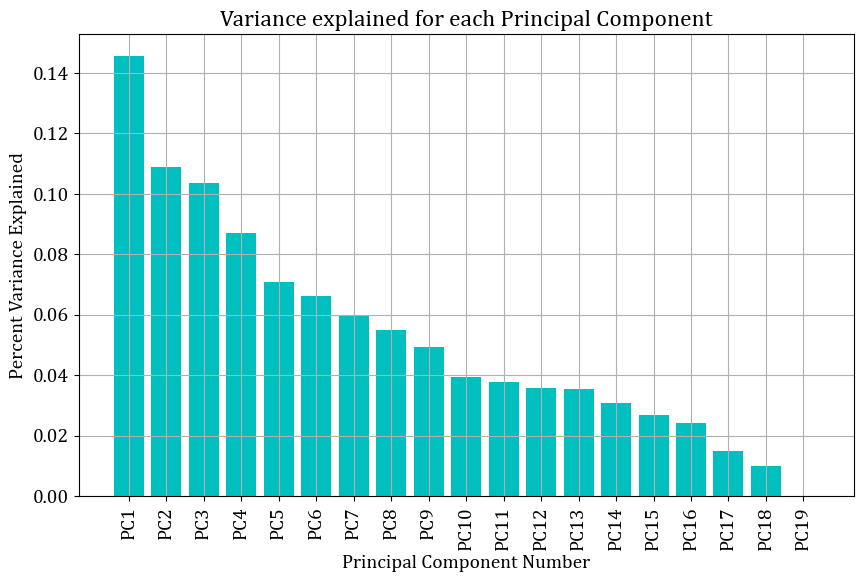

In [11]:
#@title A Closer Look at Explained Variance
plt.bar(x = ['PC1','PC2', 'PC3','PC4', 'PC5',
             'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
             'PC11', 'PC12', 'PC13', 'PC14', 'PC15',
             'PC16', 'PC17', 'PC18', 'PC19'], height = clean_explained, color='c')
plt.title('Variance explained for each Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Percent Variance Explained')
plt.xticks(rotation=90)
print('All variance is explained by the first 19 PCs')

In [12]:
#@title UMAP Preparatory Code
import umap

/Users/sowmyamanojna/Library/Python/3.9/lib/python/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sowmyamanojna/Library/Python/3.9/lib/python/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sowmyamanojna/Library/Python/3.9/lib/python/site-packages/uma

In [13]:
# import datashader as ds
# import umap.plot
# import holoviews
# import colorcet
# import skimage

In [14]:
#@title Full Data Set UMAP
clean_data_umap = umap.UMAP(random_state=420, n_neighbors=15, min_dist=0.0)
scaler = StandardScaler()
umap_clean_data_values = clean_data.iloc[:, 2:]
umap_clean_data_values.head()
scaled_clean_data = scaler.fit_transform(umap_clean_data_values)
clean_lowD_15 = clean_data_umap.fit_transform(scaled_clean_data)

clean_data_umap = umap.UMAP(random_state=420, n_neighbors=10, min_dist=0.0)
scaler = StandardScaler()
umap_clean_data_values = clean_data.iloc[:, 2:]
umap_clean_data_values.head()
scaled_clean_data = scaler.fit_transform(umap_clean_data_values)
clean_lowD_10 = clean_data_umap.fit_transform(scaled_clean_data)

clean_data_umap = umap.UMAP(random_state=420, n_neighbors=45, min_dist=0.0)
scaler = StandardScaler()
umap_clean_data_values = clean_data.iloc[:, 2:]
umap_clean_data_values.head()
scaled_clean_data = scaler.fit_transform(umap_clean_data_values)
clean_lowD_45 = clean_data_umap.fit_transform(scaled_clean_data)

clean_data_umap = umap.UMAP(random_state=420, n_neighbors=60, min_dist=0.0)
scaler = StandardScaler()
umap_clean_data_values = clean_data.iloc[:, 2:]
umap_clean_data_values.head()
scaled_clean_data = scaler.fit_transform(umap_clean_data_values)
clean_lowD_60 = clean_data_umap.fit_transform(scaled_clean_data)


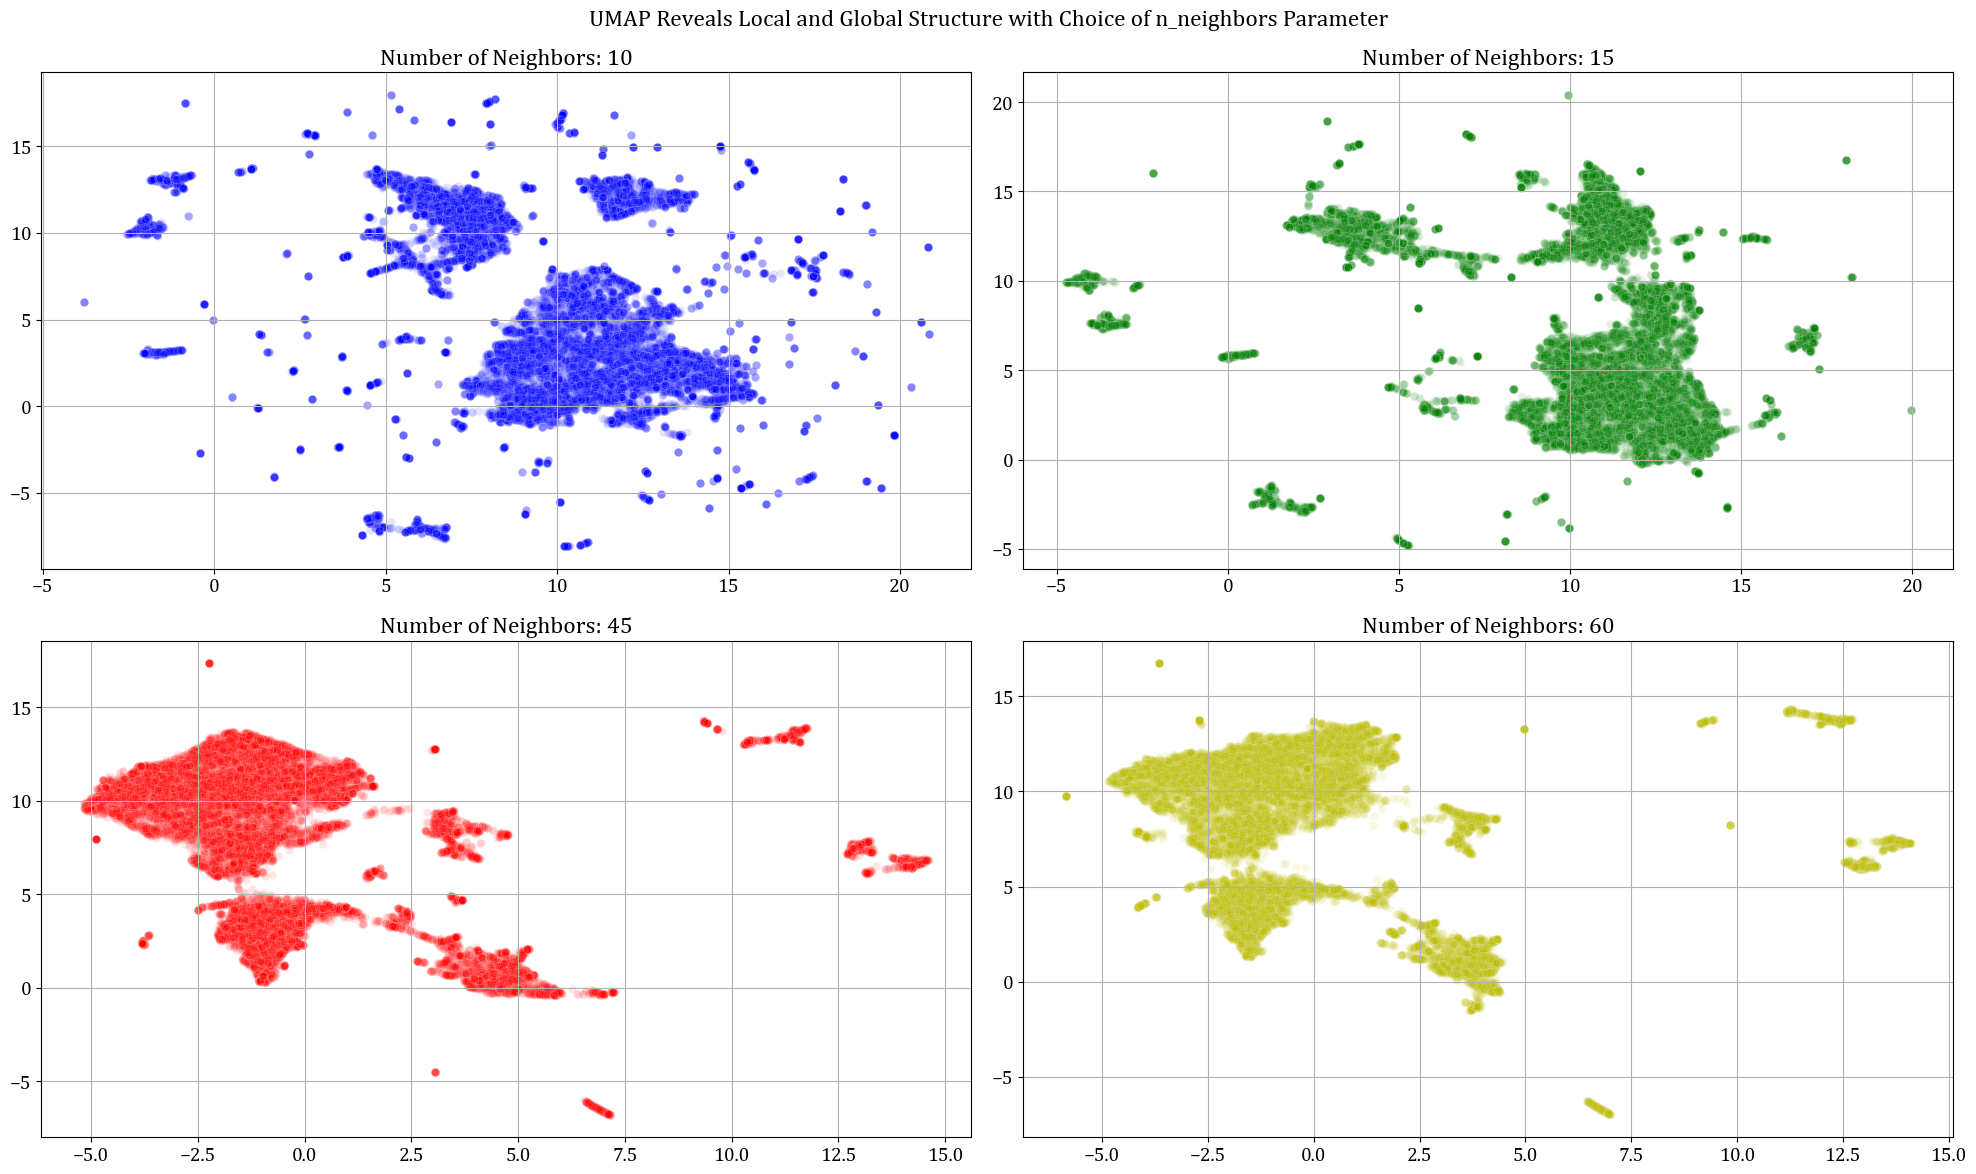

In [15]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
# plt.scatter(clean_lowD_10[:,0], clean_lowD_10[:,1], color='b', alpha=0.1)
sns.scatterplot(x=clean_lowD_10[:,0], y=clean_lowD_10[:,1], color='b', alpha=0.1)
plt.title('Number of Neighbors: 10')

plt.subplot(2, 2, 2)
# plt.scatter(clean_lowD_15[:,0], clean_lowD_15[:,1], color='g', alpha=0.1)
sns.scatterplot(x=clean_lowD_15[:,0], y=clean_lowD_15[:,1], color='g', alpha=0.1)
plt.title('Number of Neighbors: 15')

plt.subplot(2, 2, 3)
# plt.scatter(clean_lowD_45[:,0], clean_lowD_45[:,1], color='r', alpha=0.1)
sns.scatterplot(x=clean_lowD_45[:,0], y=clean_lowD_45[:,1], color='r', alpha=0.1)
plt.title('Number of Neighbors: 45')

plt.subplot(2, 2, 4)
# plt.scatter(clean_lowD_60[:,0], clean_lowD_60[:,1], color='y', alpha=0.1)
sns.scatterplot(x=clean_lowD_60[:,0], y=clean_lowD_60[:,1], color='y', alpha=0.1)
plt.title('Number of Neighbors: 60')
plt.suptitle('UMAP Reveals Local and Global Structure with Choice of n_neighbors Parameter')
plt.tight_layout()
plt.show()

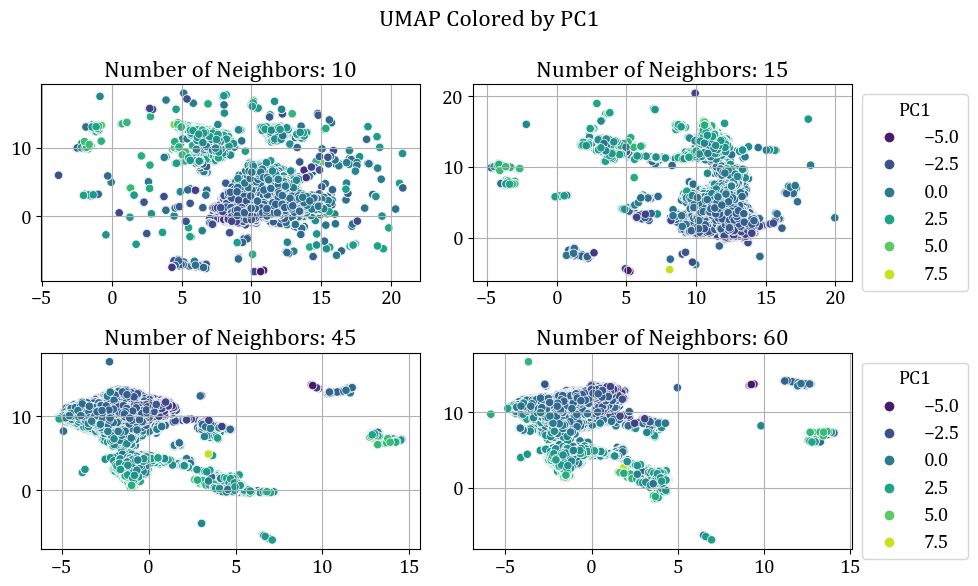

In [16]:
plt.figure()
plt.suptitle('UMAP Colored by PC1')
plt.subplot(2, 2, 1)
sns.scatterplot(x=clean_lowD_10[:,0], y=clean_lowD_10[:,1], data=clean_data_pc_values, hue='PC1', palette='viridis', legend=False)
plt.title("Number of Neighbors: 10")

plt.subplot(2, 2, 2)
a = sns.scatterplot(x=clean_lowD_15[:,0], y=clean_lowD_15[:,1], data=clean_data_pc_values, hue='PC1', palette='viridis')
plt.title("Number of Neighbors: 15")

plt.subplot(2, 2, 3)
sns.scatterplot(x=clean_lowD_45[:,0], y=clean_lowD_45[:,1], data=clean_data_pc_values, hue='PC1', palette='viridis', legend=False)
plt.title("Number of Neighbors: 45")

plt.subplot(2, 2, 4)
b = sns.scatterplot(x=clean_lowD_60[:,0], y=clean_lowD_60[:,1], data=clean_data_pc_values, hue='PC1', palette='viridis')
plt.title("Number of Neighbors: 60")

sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(b, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

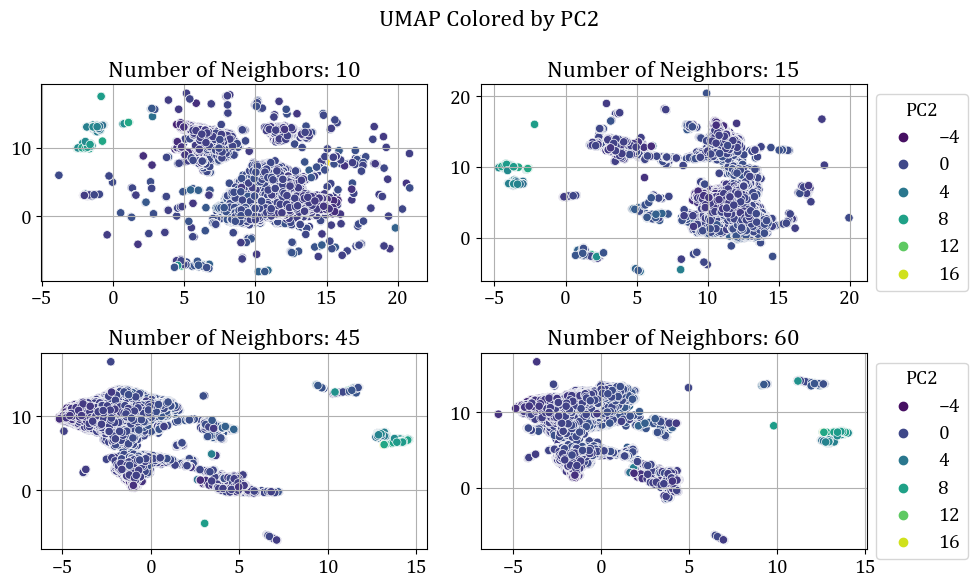

In [17]:
plt.figure()
plt.suptitle('UMAP Colored by PC2')
plt.subplot(2, 2, 1)
sns.scatterplot(x=clean_lowD_10[:,0], y=clean_lowD_10[:,1], data=clean_data_pc_values, hue='PC2', palette='viridis', legend=False)
plt.title("Number of Neighbors: 10")

plt.subplot(2, 2, 2)
a = sns.scatterplot(x=clean_lowD_15[:,0], y=clean_lowD_15[:,1], data=clean_data_pc_values, hue='PC2', palette='viridis')
plt.title("Number of Neighbors: 15")

plt.subplot(2, 2, 3)
sns.scatterplot(x=clean_lowD_45[:,0], y=clean_lowD_45[:,1], data=clean_data_pc_values, hue='PC2', palette='viridis', legend=False)
plt.title("Number of Neighbors: 45")

plt.subplot(2, 2, 4)
b = sns.scatterplot(x=clean_lowD_60[:,0], y=clean_lowD_60[:,1], data=clean_data_pc_values, hue='PC2', palette='viridis')
plt.title("Number of Neighbors: 60")

sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(b, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

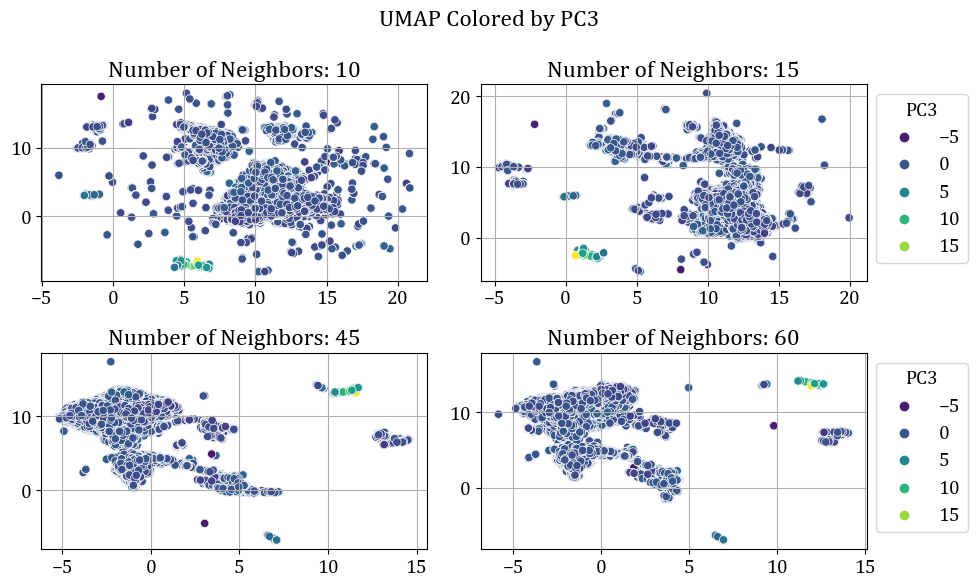

In [18]:
plt.figure()
plt.suptitle('UMAP Colored by PC3')
plt.subplot(2, 2, 1)
sns.scatterplot(x=clean_lowD_10[:,0], y=clean_lowD_10[:,1], data=clean_data_pc_values, hue='PC3', palette='viridis', legend=False)
plt.title("Number of Neighbors: 10")

plt.subplot(2, 2, 2)
a = sns.scatterplot(x=clean_lowD_15[:,0], y=clean_lowD_15[:,1], data=clean_data_pc_values, hue='PC3', palette='viridis')
plt.title("Number of Neighbors: 15")

plt.subplot(2, 2, 3)
sns.scatterplot(x=clean_lowD_45[:,0], y=clean_lowD_45[:,1], data=clean_data_pc_values, hue='PC3', palette='viridis', legend=False)
plt.title("Number of Neighbors: 45")

plt.subplot(2, 2, 4)
b = sns.scatterplot(x=clean_lowD_60[:,0], y=clean_lowD_60[:,1], data=clean_data_pc_values, hue='PC3', palette='viridis')
plt.title("Number of Neighbors: 60")

sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(b, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

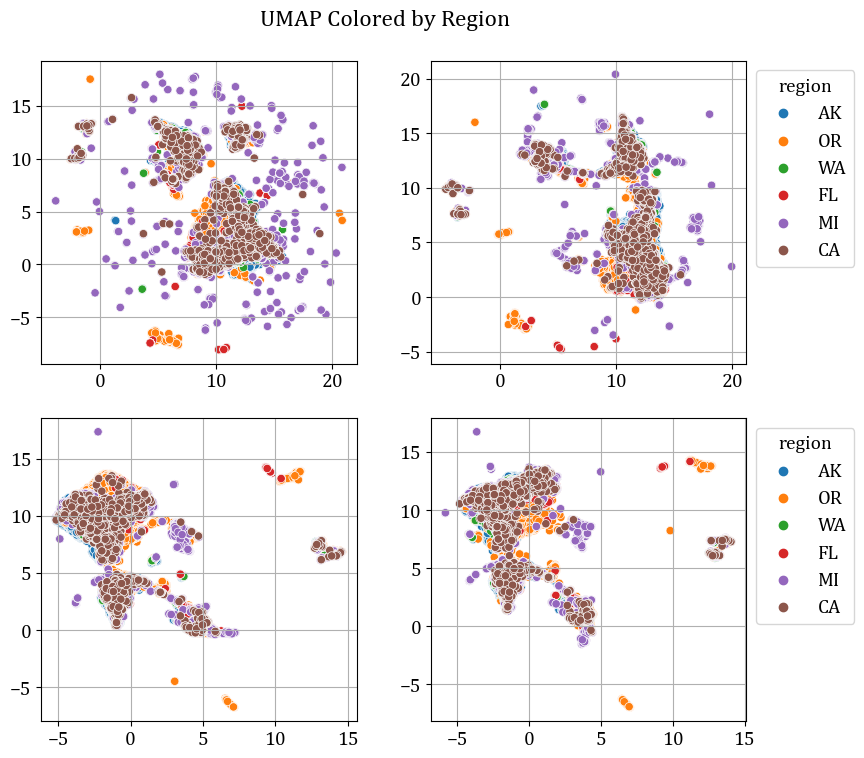

In [19]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('UMAP Colored by Region')

sns.scatterplot(ax = axes[0,0], x = clean_lowD_10[:,0], y = clean_lowD_10[:,1], data=clean_data, hue='region', palette='tab10', legend=False)
sns.scatterplot(ax = axes[0,1], x = clean_lowD_15[:,0], y = clean_lowD_15[:,1], data=clean_data, hue='region', palette='tab10')
sns.scatterplot(ax = axes[1,0], x = clean_lowD_45[:,0], y = clean_lowD_45[:,1], data=clean_data, hue='region', palette='tab10', legend=False)
sns.scatterplot(ax = axes[1,1], x = clean_lowD_60[:,0], y = clean_lowD_60[:,1], data=clean_data, hue='region', palette='tab10')


sns.move_legend(axes[0,1], "upper left", bbox_to_anchor=(1, 1))

sns.move_legend(axes[1,1], "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'UMAP with 10 Neighbors')

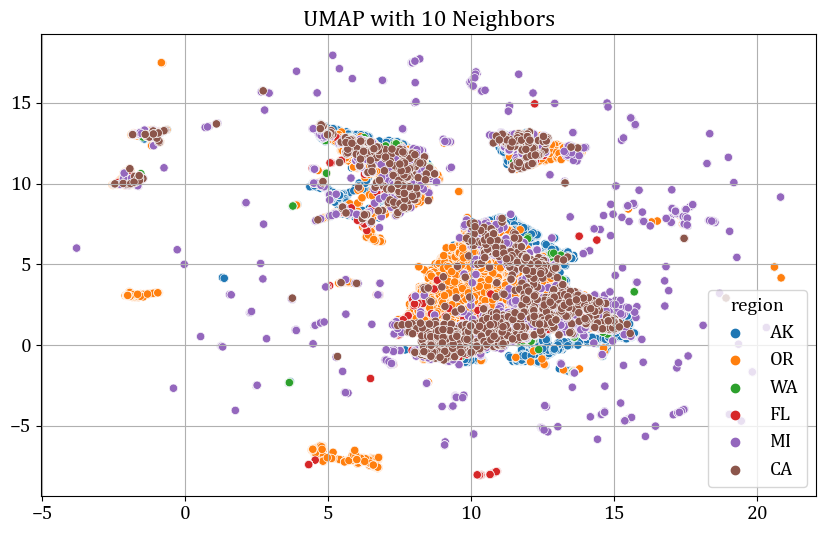

In [20]:
#@title Regional Breakdown 1
sns.scatterplot(x = clean_lowD_10[:,0], y = clean_lowD_10[:,1], data=clean_data, hue='region')
plt.title('UMAP with 10 Neighbors')

Text(0.5, 1.0, 'UMAP with 15 Neighbors')

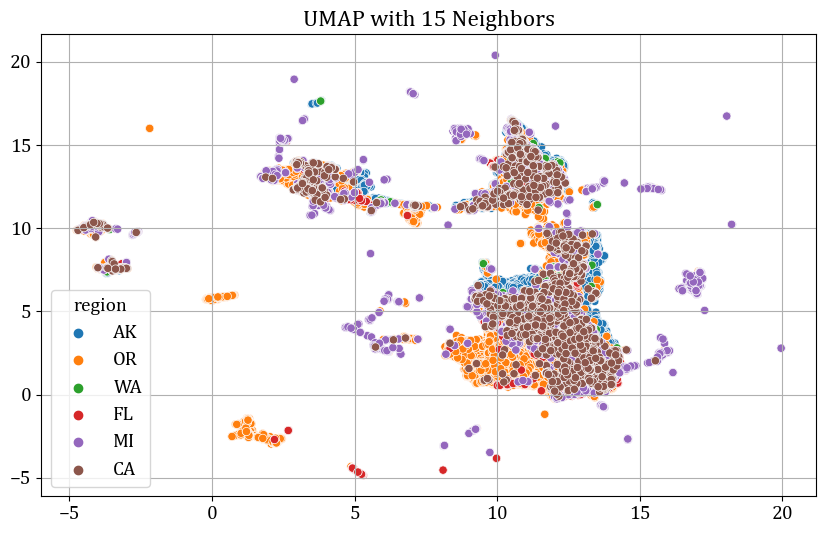

In [21]:
#@title Regional Breakdown 2
sns.scatterplot(x = clean_lowD_15[:,0], y = clean_lowD_15[:,1], data=clean_data, hue='region')
plt.title('UMAP with 15 Neighbors')

Text(0.5, 1.0, 'UMAP with 45 Neighbors')

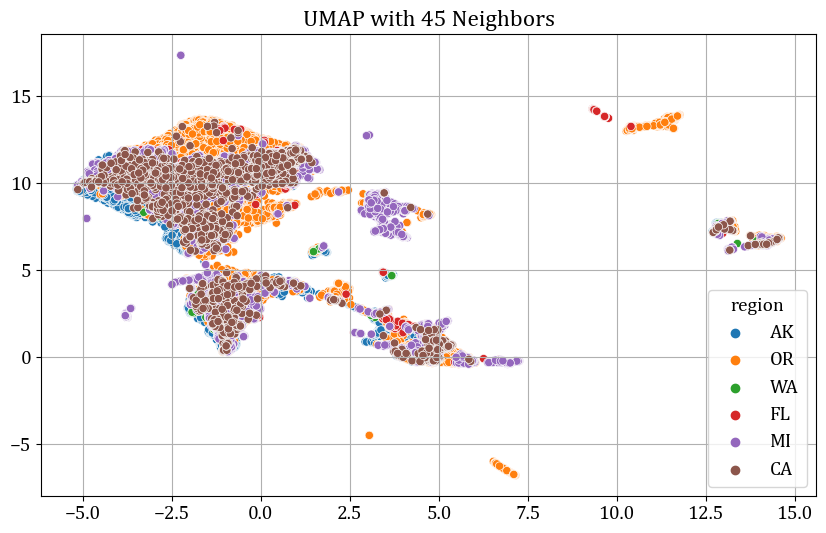

In [22]:
#@title Regional Breakdown 3
sns.scatterplot(x = clean_lowD_45[:,0], y = clean_lowD_45[:,1], data=clean_data, hue='region')
plt.title('UMAP with 45 Neighbors')

Text(0.5, 1.0, 'UMAP with 60 Neighbors')

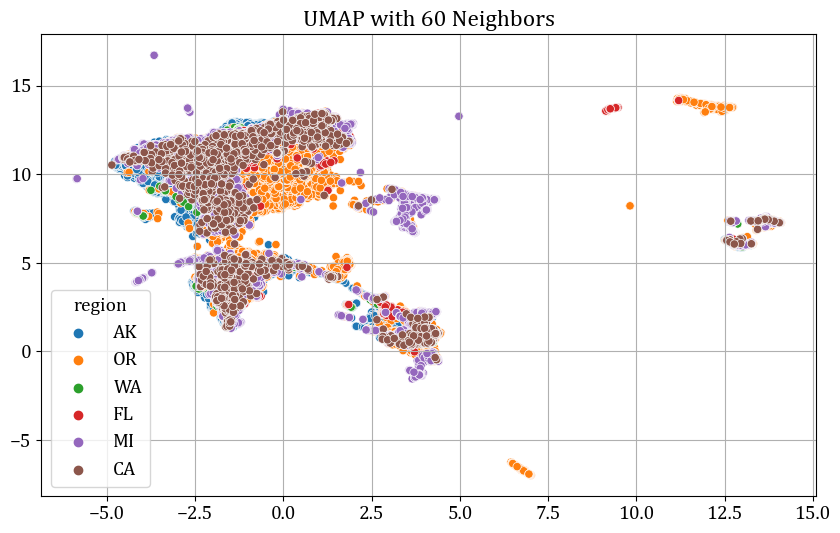

In [23]:
#@title Regional Breakdown 4
sns.scatterplot(x = clean_lowD_60[:,0], y = clean_lowD_60[:,1], data=clean_data, hue='region')
plt.title('UMAP with 60 Neighbors')

In [24]:
max_terp_data = clean_data.iloc[:,8:-2]
max_terp_data['Max Terpene']= clean_data.iloc[:,8:-2].idxmax(axis=1)
max_terp_data

tot_ocimene  camphene  g_terpinene  tot_nerolidol_ct  humulene  \
u_id                                                                    
0         0.126627  0.005041     0.007724          0.005041  0.109391   
1         0.215732  0.005758     0.008682          0.012792  0.082561   
2         0.208189  0.006220     0.008142          0.016626  0.087307   
3         0.008019  0.008019     0.008019          0.000000  0.134423   
4         0.129744  0.008177     0.011458          0.008177  0.104336   
...            ...       ...          ...               ...       ...   
88943     0.000000  0.002157     0.000000          0.030630  0.092752   
88944     0.000000  0.006301     0.000000          0.020252  0.069307   
88980     0.059835  0.002063     0.000000          0.040578  0.091472   
88998     0.000617  0.005247     0.000000          0.005864  0.047840   
88999     0.000464  0.007885     0.000000          0.006957  0.051948   

       caryophyllene  limonene  linalool   myrcene  bisabolol  b_pinene  \
u_id                                                                      
0           0.282619  0.080244  0.016521  0.089255   0.014919  0.057590   
1           0.181566  0.073240  0.005758  0.115024   0.005758  0.040225   
2           0.190361  0.069086  0.013722  0.110446   0.006220  0.036003   
3           0.308981  0.108156  0.044945  0.295542   0.039173  0.028637   
4           0.259848  0.094910  0.023999  0.081292   0.008177  0.068392   
...              ...       ...       ...       ...        ...       ...   
88943       0.290768  0.195427  0.060828  0.251079   0.029767  0.029336   
88944       0.221872  0.257426  0.109811  0.207921   0.029253  0.044104   
88980       0.191197  0.046080  0.020633  0.366575   0.038514  0.045392   
88998       0.153395  0.204321  0.042901  0.468210   0.012654  0.037346   
88999       0.166048  0.247681  0.070965  0.332560   0.020408  0.057514   

       a_terpinene    Max Terpene  
u_id                               
0         0.005041  caryophyllene  
1         0.007331    tot_ocimene  
2         0.007452    tot_ocimene  
3         0.000000  caryophyllene  
4         0.008177  caryophyllene  
...            ...            ...  
88943     0.000000  caryophyllene  
88944     0.000000       limonene  
88980     0.000000        myrcene  
88998     0.000000        myrcene  
88999     0.000000        myrcene  

[26033 rows x 13 columns]

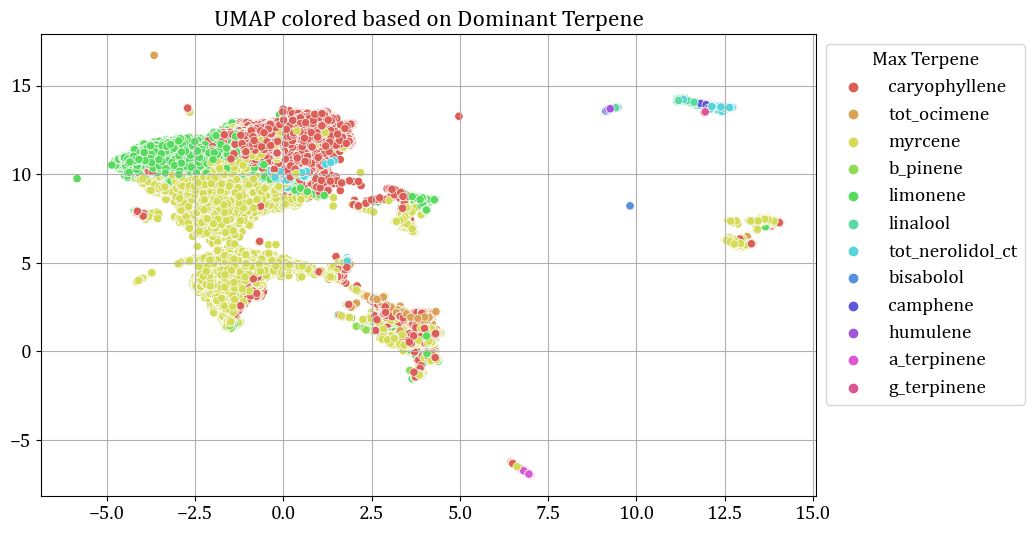

In [25]:
#@title Terpene Breakdown
ax = sns.scatterplot(x = clean_lowD_60[:,0], y = clean_lowD_60[:,1], data=max_terp_data, hue='Max Terpene', palette='hls')
plt.title('UMAP colored based on Dominant Terpene')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Part III: Clustering Analysis

Based on what I've read and watched, the primary clustering method should be DBSCAN. Like UMAP, there are some hyperparameters we can set that will affect cluster size/ noise assignment. The cool thing about DBSCAN is that it doesn't assign all of the points to a cluster, so when we eventually fit a regression model, we can try to predict cluster membership of the outlier strains.

I'm looking for a package that can do K-medoids too. It's like K-means, so that's a back-up for what I'm thinking for this second clustering analysis. One cool thing we could do if we have time for is to use K-medoids/K-means to separate the data in 3 clusters and see how well (poorly) Sativa/Hybrid/Indica labels predict a strains membership in one of the clusters. I think we can save this for later though.

In later parts, we'll use these clusters to fit linear models. I've realized that even this step has two potential approaches. 

1) We use an L2-norm penalty (Ridge Regression) which can be used for future classification problems or 

2) We use an L1-norm penalty (Lasso Regression) which can be used to make inferences about important features

Both approaches are valuable-- we can think about this more when we get to that step

In [26]:
#@title Implement DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

In [27]:
# #@title Import Knee Finder
# !pip3 install kneed

# from kneed import KneeLocator

In [28]:
#@title Estimate Epsilon for DBSCAN
clean_data_values_db = clean_data.iloc[:, 2:]
scaler = StandardScaler()
scaled_clean_data_values_db = scaler.fit_transform(clean_data_values_db)

neighbors = NearestNeighbors(n_neighbors=19)
neighbors_fit = neighbors.fit(scaled_clean_data_values_db)
distances, indices = neighbors_fit.kneighbors(scaled_clean_data_values_db)


distances = np.sort(distances, axis=0)
distances = distances[:,1]
sort_index = np.arange(len(distances))
# kl = KneeLocator(sort_index, distances, curve="convex")

# print(kl.all_knees_y)

#eps_line = eps_val * np.ones(len(distances))

#plt.plot(eps_line)
#plt.plot(distances)
# KneeLocator.plot_knee(kl)
# plt.xlabel('Points (sorted by distance)')
# plt.ylabel('19-NN distance')
# plt.title('Nearest Neighbor Plot for Full Dataset')

In [29]:
#@title DBSCAN Clustering of Full Dataset
#Record Parameters like this (eps=val, min_sampes=val) {cluster, noise, SC}

#(2.3, 19) {6, 1308, 0.681} : Also pretty believable ****
#(3.5,19) {4, 431, 0.647} : This one is pretty good too, but it completely misses high CBD strains ****

#(1.75,38) {4,4387,0.645}****
#(2.3,38) {5,1738,0.676} : Honestly v believable ****

db = DBSCAN(eps=1.75, min_samples=38).fit(scaled_clean_data_values_db)
labels = db.labels_
clean_data_values_db['assignments'] = labels
clean_data_values_db_clustered = clean_data_values_db.loc[clean_data_values_db.assignments >= 0]

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
#labels_clustered = labels
#for assignment in range(len(labels)):
#  if labels[assignment] < 0:
#    labels_clustered = np.delete(labels_clustered, [assignment])


print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Silhouette Coefficient: {metrics.silhouette_score(clean_data_values_db, labels):.3f}")

Estimated number of clusters: 4
Estimated number of noise points: 4387
Silhouette Coefficient: 0.645


In [30]:
clean_data_values_db

tot_thc   tot_cbd   tot_cbg   tot_cbc  tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
0      0.934875  0.002195  0.051035  0.000000      0.0  0.011895     0.126627   
1      0.942376  0.004544  0.047952  0.002478      0.0  0.002651     0.215732   
2      0.942578  0.004096  0.047829  0.002907      0.0  0.002590     0.208189   
3      0.966836  0.003003  0.025930  0.001726      0.0  0.002504     0.008019   
4      0.934829  0.003692  0.049598  0.000000      0.0  0.011880     0.129744   
...         ...       ...       ...       ...      ...       ...          ...   
88943  0.938651  0.002171  0.059177  0.000000      0.0  0.000000     0.000000   
88944  0.950399  0.002075  0.047527  0.000000      0.0  0.000000     0.000000   
88980  0.969916  0.002917  0.026502  0.000665      0.0  0.000000     0.059835   
88998  0.970867  0.002627  0.026506  0.000000      0.0  0.000000     0.000617   
88999  0.968337  0.002012  0.029651  0.000000      0.0  0.000000     0.000464   

       camphene  g_terpinene  tot_nerolidol_ct  ...  caryophyllene  limonene  \
u_id                                            ...                            
0      0.005041     0.007724          0.005041  ...       0.282619  0.080244   
1      0.005758     0.008682          0.012792  ...       0.181566  0.073240   
2      0.006220     0.008142          0.016626  ...       0.190361  0.069086   
3      0.008019     0.008019          0.000000  ...       0.308981  0.108156   
4      0.008177     0.011458          0.008177  ...       0.259848  0.094910   
...         ...          ...               ...  ...            ...       ...   
88943  0.002157     0.000000          0.030630  ...       0.290768  0.195427   
88944  0.006301     0.000000          0.020252  ...       0.221872  0.257426   
88980  0.002063     0.000000          0.040578  ...       0.191197  0.046080   
88998  0.005247     0.000000          0.005864  ...       0.153395  0.204321   
88999  0.007885     0.000000          0.006957  ...       0.166048  0.247681   

       linalool   myrcene  bisabolol  b_pinene  a_terpinene  terpinolene  \
u_id                                                                       
0      0.016521  0.089255   0.014919  0.057590     0.005041     0.161961   
1      0.005758  0.115024   0.005758  0.040225     0.007331     0.210494   
2      0.013722  0.110446   0.006220  0.036003     0.007452     0.209503   
3      0.044945  0.295542   0.039173  0.028637     0.000000     0.000000   
4      0.023999  0.081292   0.008177  0.068392     0.008177     0.147166   
...         ...       ...        ...       ...          ...          ...   
88943  0.060828  0.251079   0.029767  0.029336     0.000000     0.000000   
88944  0.109811  0.207921   0.029253  0.044104     0.000000     0.008101   
88980  0.020633  0.366575   0.038514  0.045392     0.000000     0.000000   
88998  0.042901  0.468210   0.012654  0.037346     0.000000     0.002160   
88999  0.070965  0.332560   0.020408  0.057514     0.000000     0.006957   

       a_pinene  assignments  
u_id                          
0      0.038028            0  
1      0.035078            0  
2      0.030722            0  
3      0.016085            0  
4      0.046147            0  
...         ...          ...  
88943  0.017256            0  
88944  0.025653            0  
88980  0.097662            0  
88998  0.019444            0  
88999  0.030612            0  

[26033 rows x 21 columns]

In [31]:
#@title Generate Cluster Profiles
db_cluster_1 = clean_data_values_db.loc[clean_data_values_db['assignments']==0]
db_cluster_1 = db_cluster_1.drop(columns = ['assignments'])

db_cluster_2 = clean_data_values_db.loc[clean_data_values_db['assignments']==1]
db_cluster_2 = db_cluster_2.drop(columns = ['assignments'])

db_cluster_3 = clean_data_values_db.loc[clean_data_values_db['assignments']==2]
db_cluster_3 = db_cluster_3.drop(columns = ['assignments'])

db_cluster_4 = clean_data_values_db.loc[clean_data_values_db['assignments']==3]
db_cluster_4 = db_cluster_4.drop(columns = ['assignments'])

db_cluster_0 = clean_data_values_db.loc[clean_data_values_db['assignments']==-1]
db_cluster_0 = db_cluster_0.drop(columns = ['assignments'])

In [32]:
import os
os.getcwd()

'/Users/sowmyamanojna/Desktop/spr23/cogs209/project/mp2'

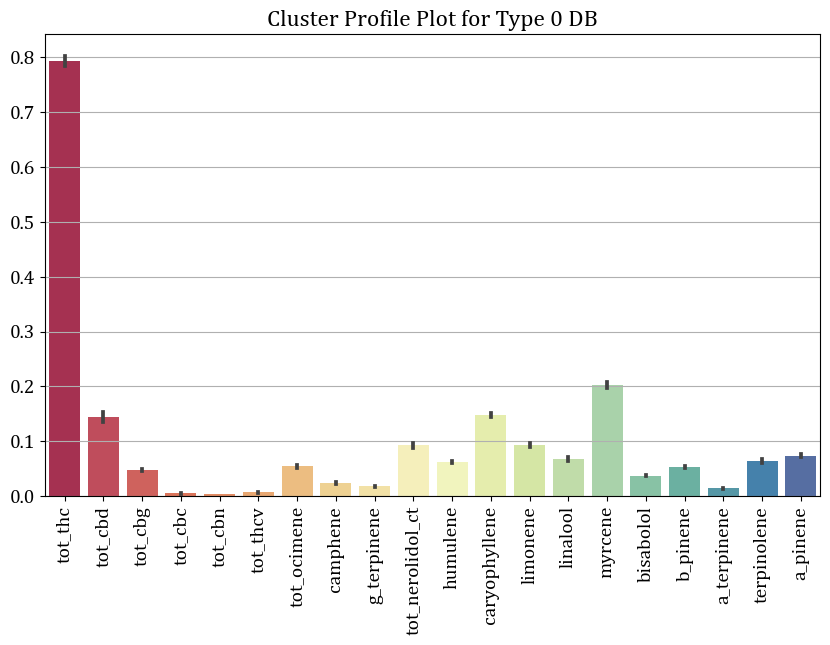

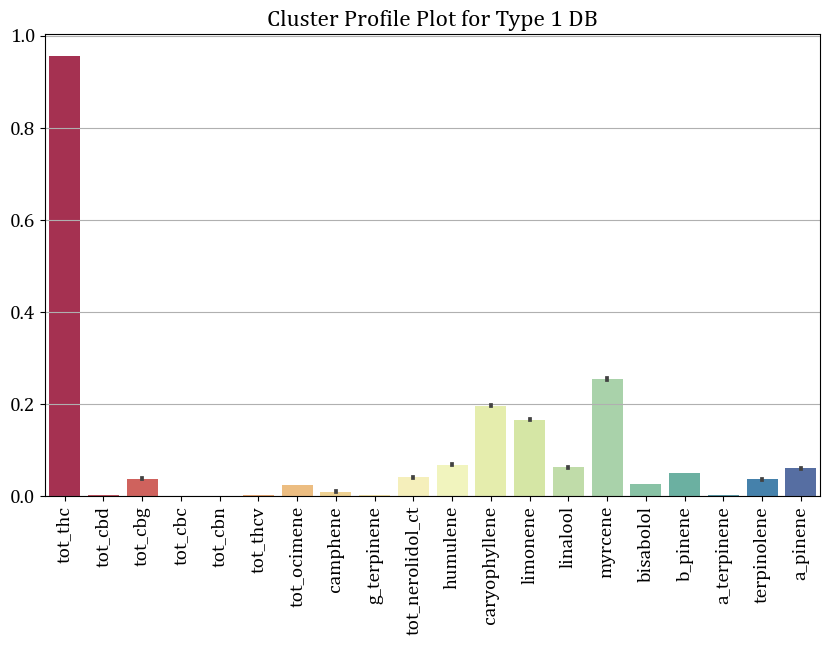

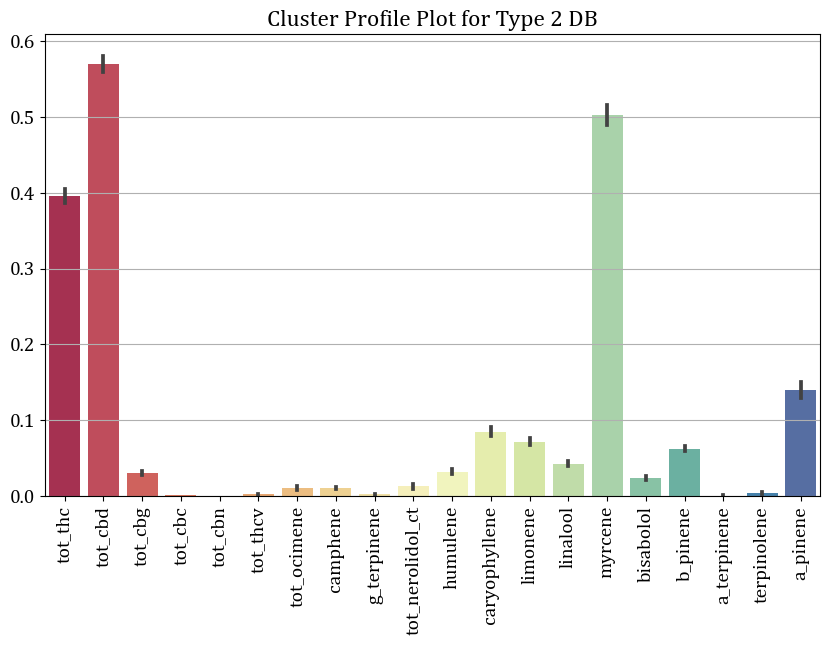

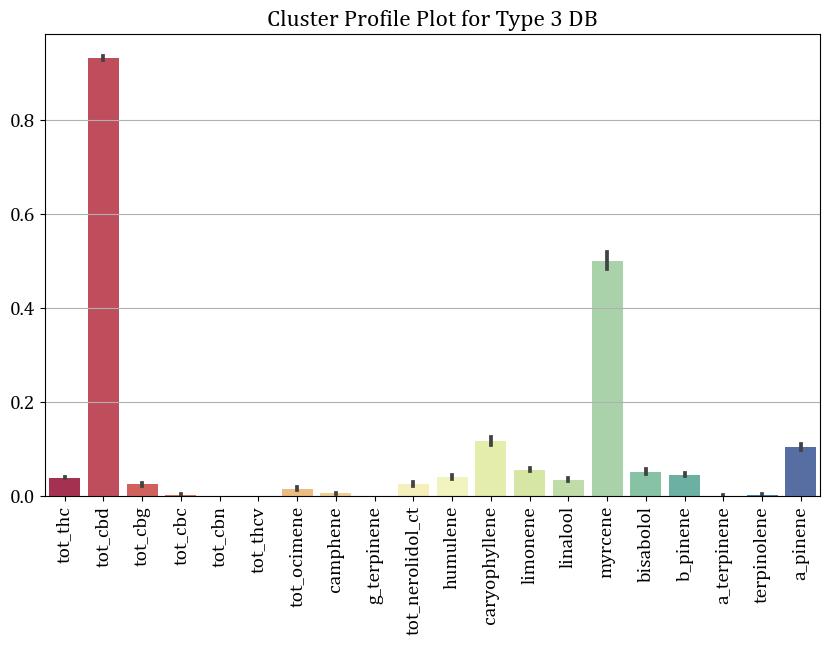

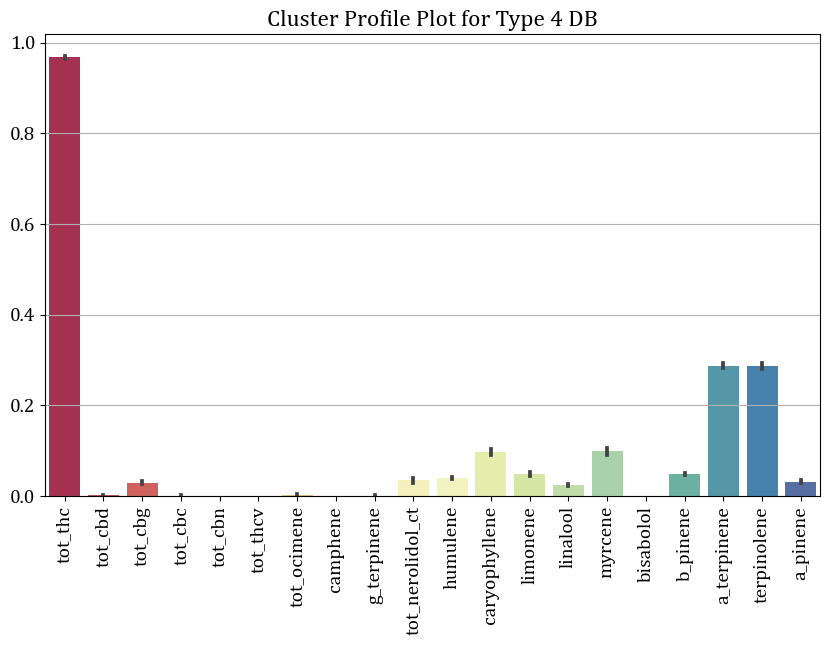

In [33]:
clusters = np.unique(clean_data_values_db["assignments"])
for i in clusters:
    db_tmp = clean_data_values_db.loc[clean_data_values_db['assignments']==i]
    db_tmp = db_tmp.drop(columns = ['assignments'])
    
    plt.figure()
    sns.barplot(data=db_tmp, palette="Spectral")
    plt.xticks(rotation=90)
    plt.title('Cluster Profile Plot for Type {} DB'.format(i+1))
    plt.savefig("images/db_cluster_"+str(i+1)+".png")
    plt.show()

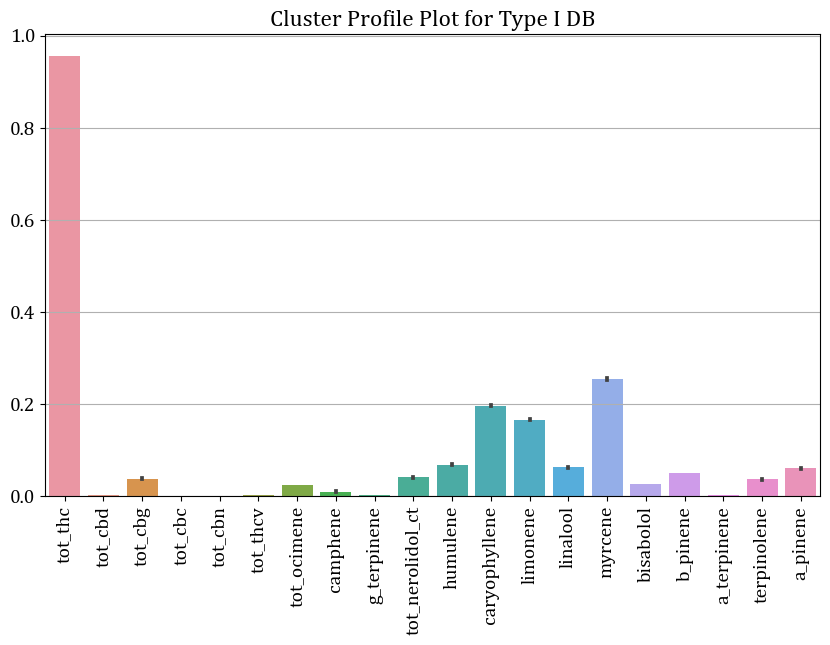

In [34]:
#@title Plot (KMC4) Cluster 1
plt.figure()
sns.barplot(data=db_cluster_1)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 1 DB')
plt.show()

In [35]:
#@title Cluster 1 (KMC 4) Statistics
db_cluster_1.loc['mean'] = db_cluster_1.mean()
#Cluster_1.loc['mean']
db_cluster_1.loc['std'] = db_cluster_1.std()
print(len(db_cluster_1))
db_cluster_1.loc[['mean','std']]

21201


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.955419  0.003185  0.037935  0.001017  0.000575  0.001869     0.024329   
std   0.021839  0.005376  0.020391  0.002191  0.001617  0.004201     0.043914   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.009784     0.002426          0.040421  0.068002       0.196367   
std   0.007972     0.005129          0.057738  0.041092       0.109001   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.165870  0.062414  0.254902   0.026367  0.049874      0.00213   
std   0.109721  0.044944  0.172376   0.023339  0.028174      0.00533   

      terpinolene  a_pinene  
u_id                         
mean     0.036505  0.060607  
std      0.096362  0.071199

Text(0.5, 1.0, 'Cluster Profile Plot for Type II DB')

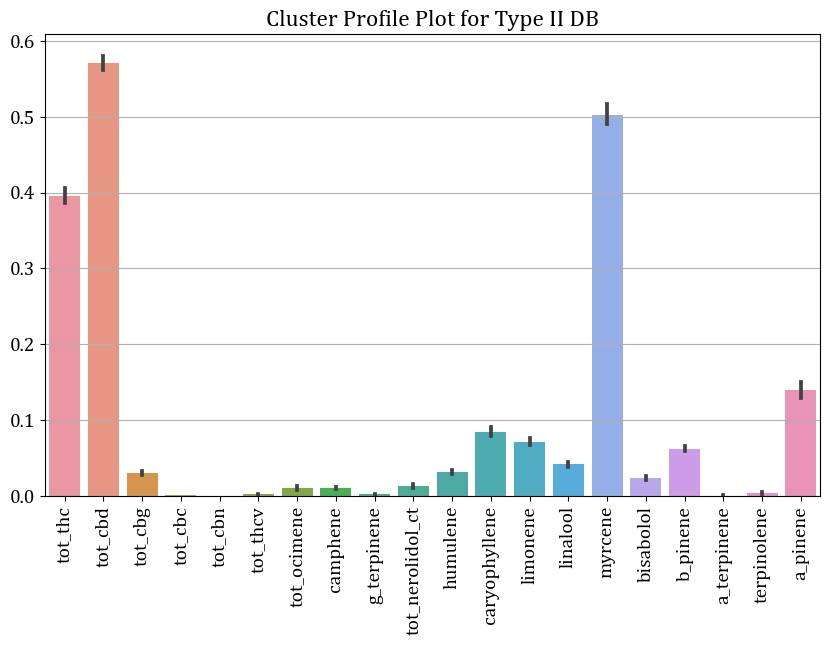

In [36]:
#@title Plot (KMC4) Cluster 2
sns.barplot(data=db_cluster_2)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type II DB')

In [37]:
#@title Cluster 1 Statistics
db_cluster_2.loc['mean'] = db_cluster_2.mean()
#Cluster_1.loc['mean']
db_cluster_2.loc['std'] = db_cluster_2.std()
print(len(db_cluster_2))
db_cluster_2.loc[['mean','std']]

153


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.396095  0.570469  0.030037  0.001116  0.000194  0.002089     0.010707   
std   0.060670  0.059980  0.014910  0.001754  0.000615  0.003504     0.016302   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.010065     0.002546          0.012618  0.031927       0.085044   
std   0.007543     0.004360          0.017695  0.017749       0.037029   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.071809  0.042079  0.502764   0.023563  0.062299     0.000557   
std   0.028610  0.020843  0.084801   0.016948  0.021643     0.002136   

      terpinolene  a_pinene  
u_id                         
mean     0.004044  0.139978  
std      0.006491  0.065216

Text(0.5, 1.0, 'Cluster Profile Plot for Type III DB')

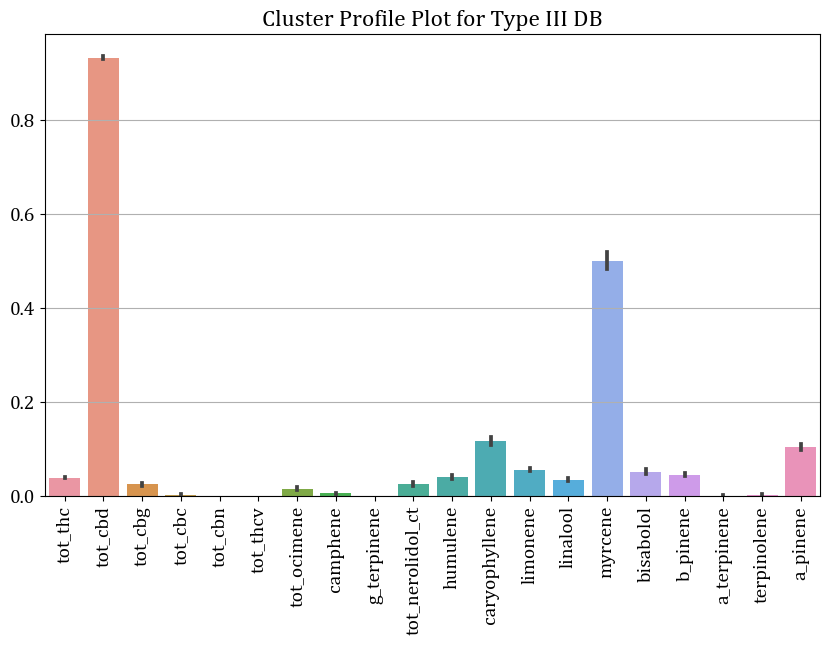

In [38]:
#@title Plot (KMC4) Cluster 3
sns.barplot(data=db_cluster_3)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type III DB')

In [39]:
#@title Cluster 3 Statistics
db_cluster_3.loc['mean'] = db_cluster_3.mean()
#Cluster_1.loc['mean']
db_cluster_3.loc['std'] = db_cluster_3.std()
print(len(db_cluster_3))
db_cluster_3.loc[['mean','std']]

146


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.039302  0.932037  0.025184  0.002921  0.000176  0.000379     0.015618   
std   0.011067  0.022185  0.018226  0.002715  0.000533  0.000916     0.021002   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.005625     0.000521          0.025035  0.040236       0.116852   
std   0.007684     0.002345          0.024970  0.021070       0.055515   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.055990  0.034660  0.500763   0.051542  0.045530     0.000635   
std   0.019094  0.021561  0.110028   0.031396  0.016131     0.002774   

      terpinolene  a_pinene  
u_id                         
mean     0.003206  0.103788  
std      0.006685  0.042367

Text(0.5, 1.0, 'Cluster Profile Plot for Type IV DB')

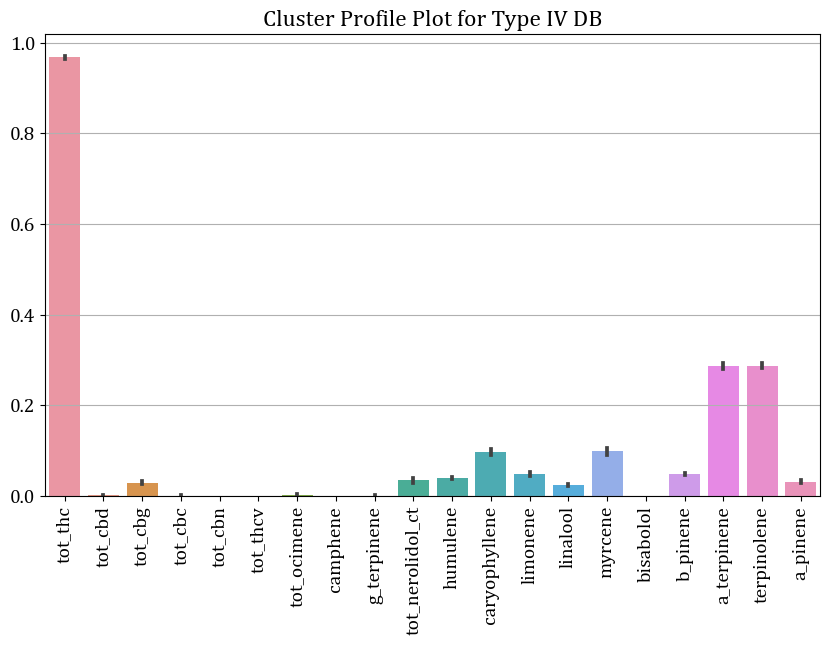

In [40]:
#@title Plot (DB) Cluster 4
sns.barplot(data=db_cluster_4)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type IV DB')

In [41]:
#@title Cluster 4 Statistics
db_cluster_4.loc['mean'] = db_cluster_4.mean()
#Cluster_4.loc['mean']
db_cluster_4.loc['std'] = db_cluster_4.std()
print(len(db_cluster_4))
db_cluster_4.loc[['mean','std']]

154


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.967765  0.001320  0.029577  0.000871  0.000358  0.000109     0.002311   
std   0.017972  0.002532  0.017519  0.001988  0.001081  0.000659     0.011772   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.000153     0.000863          0.034295  0.039884       0.096867   
std   0.001324     0.002688          0.030904  0.018988       0.043506   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.048409  0.023391  0.098386        0.0  0.048688     0.287359   
std   0.026086  0.013804  0.045460        0.0  0.018598     0.038521   

      terpinolene  a_pinene  
u_id                         
mean     0.287359  0.032036  
std      0.038521  0.015712

Text(0.5, 1.0, 'Cluster Profile Plot for Type 0 DB')

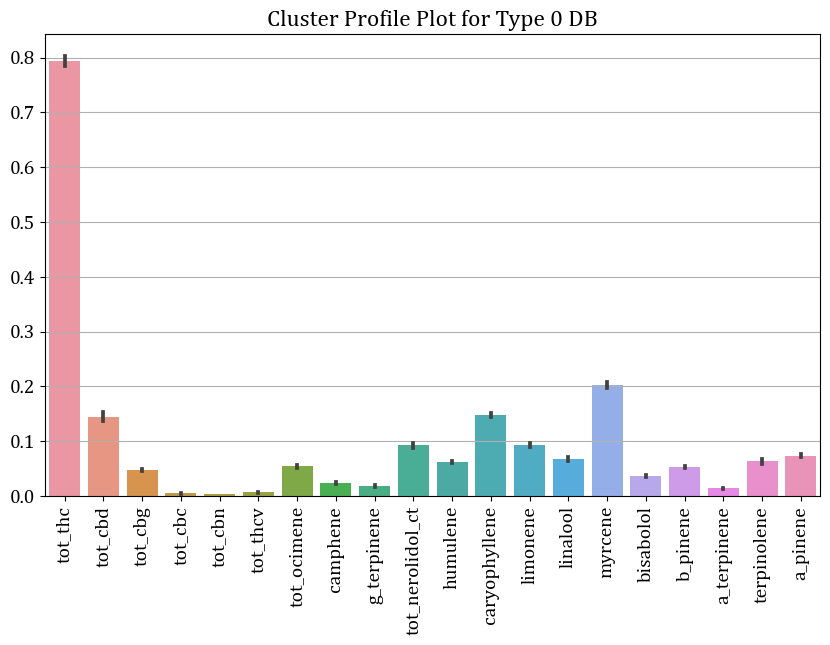

In [42]:
#@title Plot (DB) Cluster -1
sns.barplot(data=db_cluster_0)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 0 DB')

In [43]:
#@title Cluster 4 Statistics
db_cluster_0.loc['mean'] = db_cluster_0.mean()
#Cluster_4.loc['mean']
db_cluster_0.loc['std'] = db_cluster_0.std()
print(len(db_cluster_0))
db_cluster_0.loc[['mean','std']]

4389


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.794057  0.144817  0.046748  0.004688  0.003221  0.006469     0.054411   
std   0.299093  0.299268  0.060503  0.012645  0.006368  0.027513     0.098516   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.023144     0.017630          0.092243  0.061688       0.147757   
std   0.057351     0.052261          0.160599  0.073830       0.125992   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.092652  0.067563  0.202237   0.037283  0.052816     0.014044   
std   0.109124  0.114183  0.170002   0.056784  0.048404     0.044636   

      terpinolene  a_pinene  
u_id                         
mean     0.063067  0.073464  
std      0.122884  0.089803

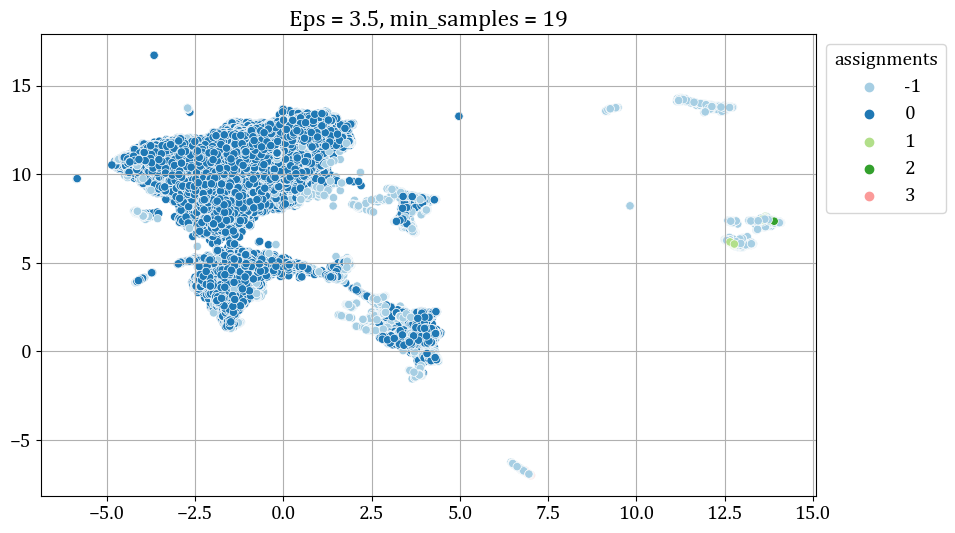

In [44]:
#@title Plot Clusters onto UMAP
#handles = np.unique(labels)
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='assignments', palette='Paired', marker='o')
ax.set_title('Eps = 3.5, min_samples = 19')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

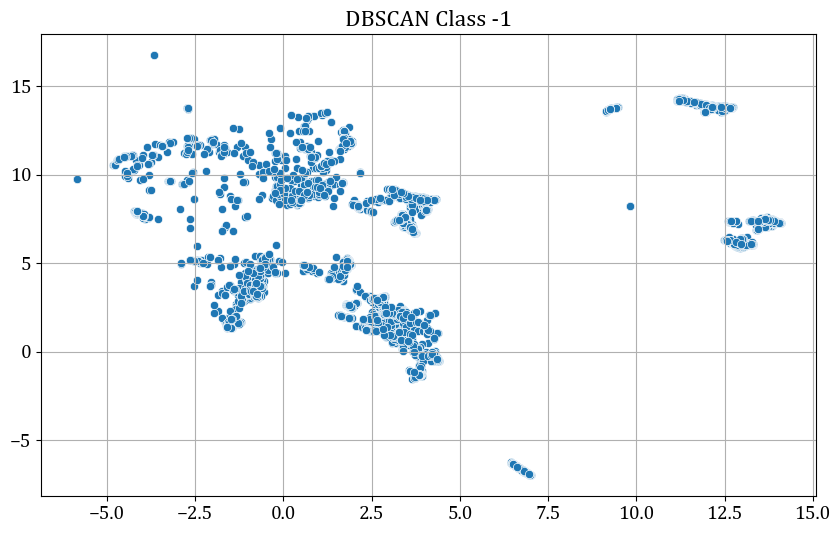

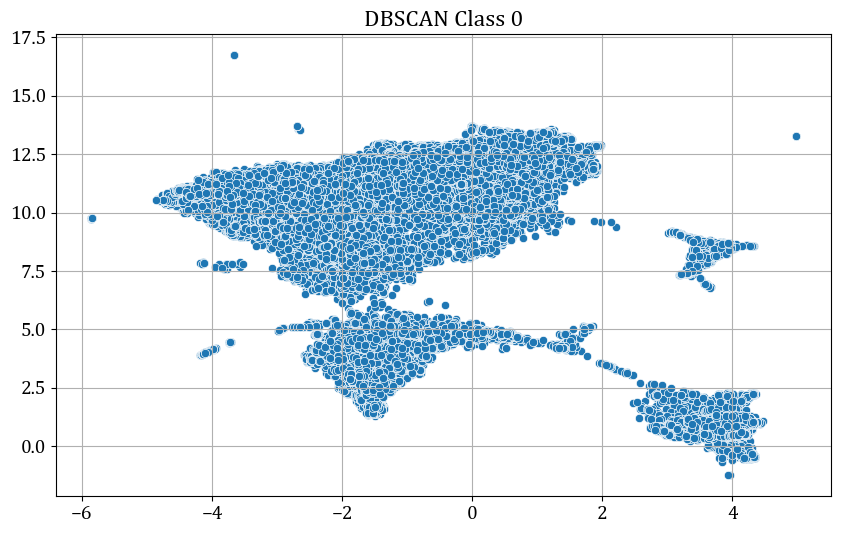

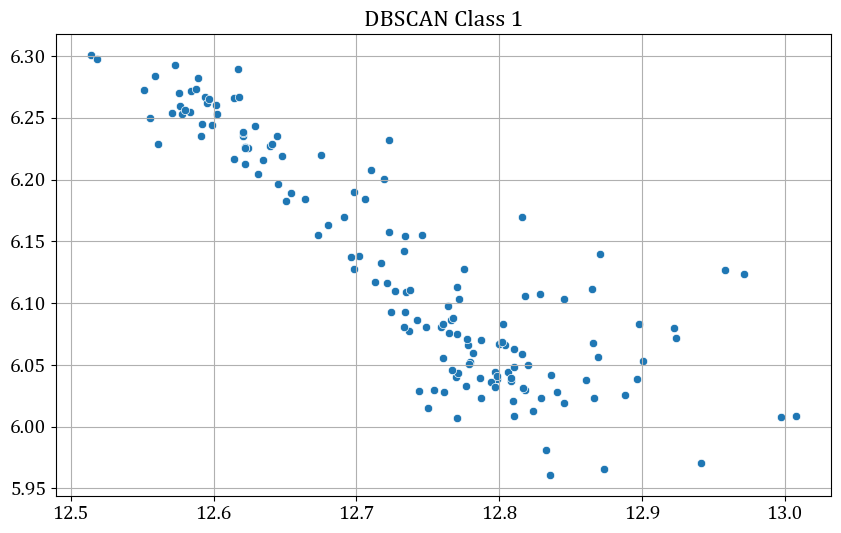

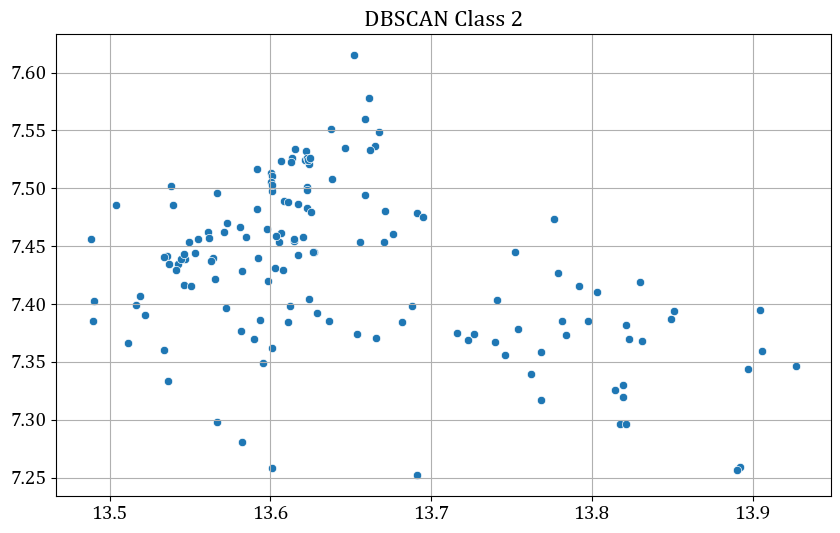

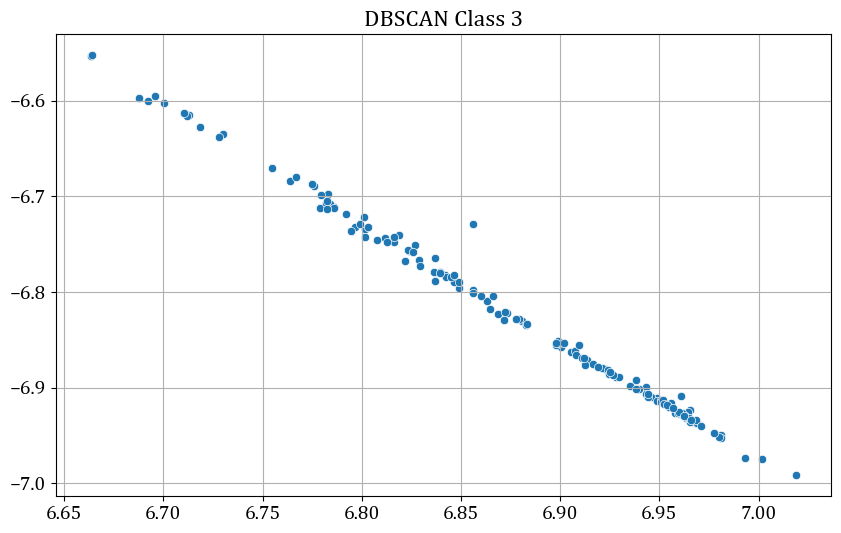

In [45]:
cluster_idxs = np.unique(clean_data_values_db["assignments"])
for cluster_idx in cluster_idxs:
    flag = np.where(clean_data_values_db["assignments"] == cluster_idx)[0]
    ax = sns.scatterplot(x=clean_lowD_60[flag, 0],y=clean_lowD_60[flag, 1], marker='o')
    ax.set_title('DBSCAN Class '+str(cluster_idx))
    plt.show()

# K-Means Clustering

In [46]:
#@title K-Means Clustering
#Here is the linear clustering algoritm. I've set the number of clusters to a few values that you can use for the model comparison,
#but you can change it to work better for you.
from sklearn.cluster import KMeans
scaled_clean_data_values_kmeans_2 = KMeans(n_clusters=2, random_state=420, n_init="auto").fit(scaled_clean_data_values_db)
labels_2 = scaled_clean_data_values_kmeans_2.labels_
clean_data_values_db['KM2 Classes'] = labels_2

scaled_clean_data_values_kmeans_4 = KMeans(n_clusters=4, random_state=420, n_init="auto").fit(scaled_clean_data_values_db)
labels_4 = scaled_clean_data_values_kmeans_4.labels_
clean_data_values_db['KM4 Classes'] = labels_4

scaled_clean_data_values_kmeans_6 = KMeans(n_clusters=6, random_state=420, n_init="auto").fit(scaled_clean_data_values_db)
labels_6 = scaled_clean_data_values_kmeans_6.labels_
clean_data_values_db['KM6 Classes'] = labels_6

scaled_clean_data_values_kmeans_8 = KMeans(n_clusters=8, random_state=420, n_init="auto").fit(scaled_clean_data_values_db)
labels_8 = scaled_clean_data_values_kmeans_8.labels_
clean_data_values_db['KM8 Classes'] = labels_8

## K-Means: K=2

In [47]:
clusters = np.unique(clean_data_values_db["assignments"])
for i in clusters:
    db_tmp = clean_data_values_db.loc[clean_data_values_db['assignments']==i]
    db_tmp = db_tmp.drop(columns = ['assignments'])
    
    plt.figure()
    sns.barplot(data=db_tmp, palette="Spectral")
    plt.xticks(rotation=90)
    plt.title('Cluster Profile Plot for Type {} DB'.format(i+1))
    plt.savefig("images/db_cluster_"+str(i+1)+".png")
    plt.show()

SyntaxError: invalid syntax (3249380281.py, line 1)

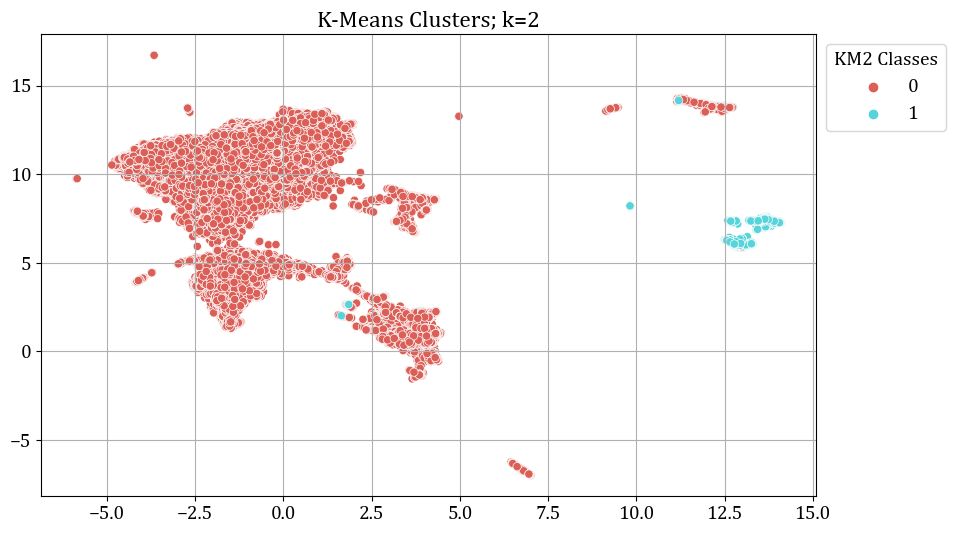

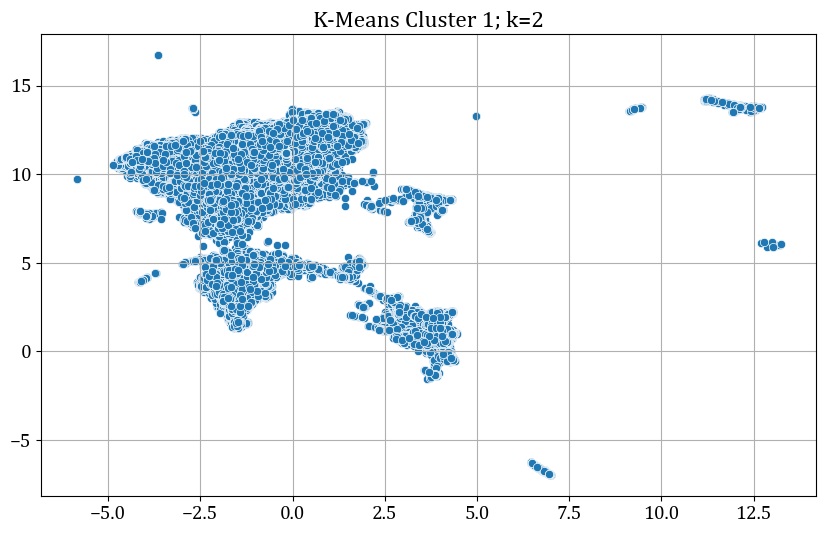

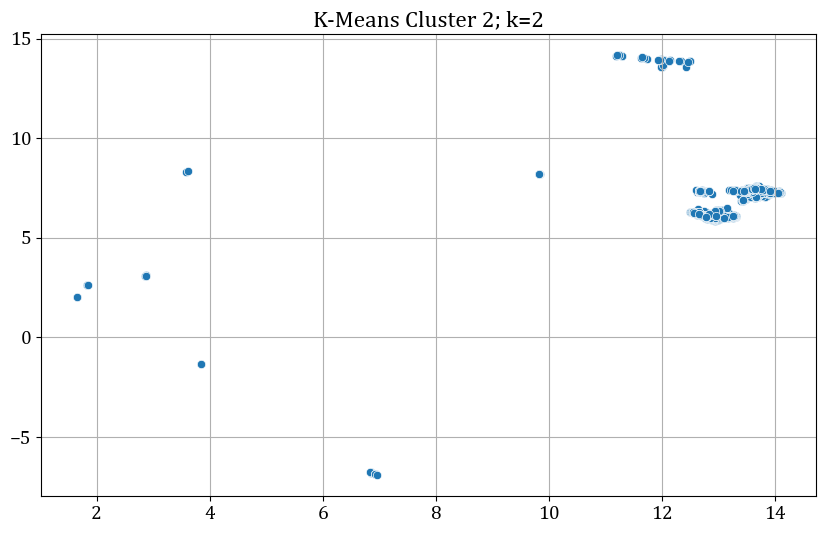

In [48]:
#@title Plot with K-Means Cluster
plt.figure()
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='KM2 Classes', palette='hls', marker='o')
ax.set_title('K-Means Clusters; k=2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

for i in range(2):
    flag = np.where(labels_2 == i)[0]
    plt.figure()
    ax = sns.scatterplot(x=clean_lowD_60[flag, 0],y=clean_lowD_60[flag, 1], marker='o')
    ax.set_title('K-Means Cluster {}; k=2'.format(i+1))
    plt.show()

In [49]:
#@title Generate Cluster Profiles
kmc2_cluster_1 = clean_data_values_db.loc[clean_data_values_db['KM2 Classes']==0]
kmc2_cluster_1 = kmc2_cluster_1.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc2_cluster_2 = clean_data_values_db.loc[clean_data_values_db['KM2 Classes']==1]
kmc2_cluster_2 = kmc2_cluster_2.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc2_cluster_2.head()


tot_thc   tot_cbd   tot_cbg   tot_cbc  tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                           
100   0.037730  0.948376  0.013894  0.000000      0.0  0.000000     0.006685   
186   0.287597  0.661286  0.043792  0.007326      0.0  0.000000     0.057887   
187   0.431625  0.538030  0.025565  0.004780      0.0  0.000000     0.000000   
188   0.341052  0.616974  0.035462  0.004597      0.0  0.001915     0.007325   
189   0.321938  0.629434  0.042931  0.003601      0.0  0.002096     0.114156   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
100   0.006685     0.000000          0.053355  0.025945       0.085781   
186   0.008830     0.011070          0.000000  0.146396       0.365806   
187   0.009186     0.000000          0.000000  0.157851       0.432163   
188   0.007325     0.000000          0.007325  0.117178       0.289612   
189   0.009964     0.017212          0.000000  0.083477       0.195895   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
100   0.046773  0.031685  0.471230   0.087552  0.063575     0.000000   
186   0.047624  0.045724  0.106285   0.046715  0.054322     0.008830   
187   0.088808  0.096744  0.144543   0.018565  0.026536     0.000000   
188   0.141038  0.007325  0.363712   0.016196  0.027242     0.000000   
189   0.090742  0.031981  0.101802   0.014830  0.081204     0.009964   

      terpinolene  a_pinene  
u_id                         
100      0.000000  0.120736  
186      0.066429  0.034082  
187      0.009186  0.016418  
188      0.000000  0.015722  
189      0.189698  0.059075

In [50]:
kmc2_cluster_2.shape

(1137, 20)

Text(0.5, 1.0, 'Cluster Profile Plot for Type 1 KMC2')

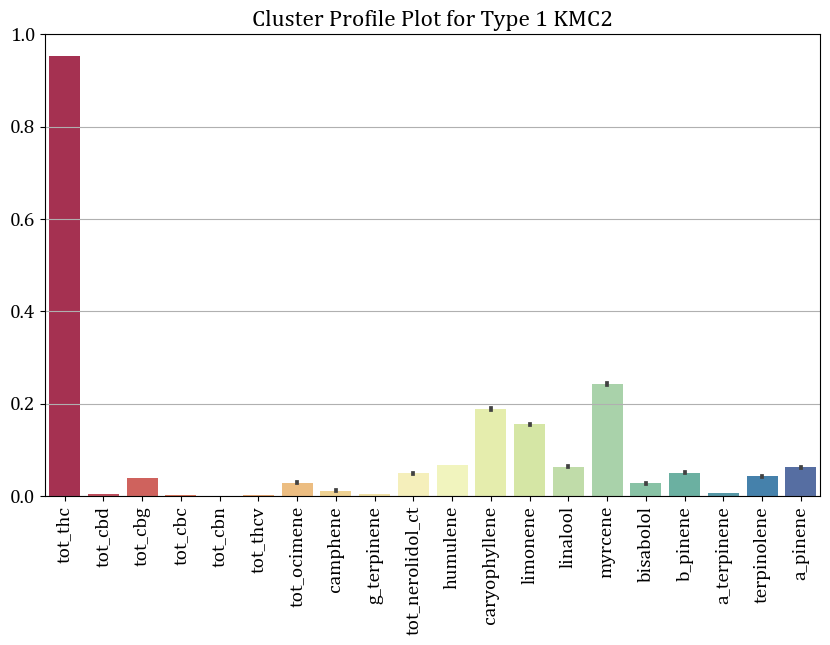

In [51]:
#@title Plot (KMC2) Cluster 1
sns.barplot(data=kmc2_cluster_1, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 1 KMC2')

In [52]:
#@title Cluster 1 Statistics
kmc2_cluster_1.loc['mean'] = kmc2_cluster_1.mean()
#Cluster_1.loc['mean']
kmc2_cluster_1.loc['std'] = kmc2_cluster_1.std()
kmc2_cluster_1.loc[['mean','std']]

tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.952227  0.003695  0.039076  0.001400  0.001005  0.002597     0.029191   
std   0.029311  0.012105  0.024110  0.003499  0.002988  0.008275     0.058064   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.011929     0.004912          0.048976  0.067021       0.188157   
std   0.024740     0.022277          0.086383  0.048500       0.113713   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.154981  0.063552  0.242726   0.027220  0.050639     0.005829   
std   0.113374  0.062475  0.171874   0.029953  0.032460     0.029342   

      terpinolene  a_pinene  
u_id                         
mean     0.042837  0.062032  
std      0.103954  0.074160

Text(0.5, 1.0, 'Cluster Profile Plot for Type 2 KMC2')

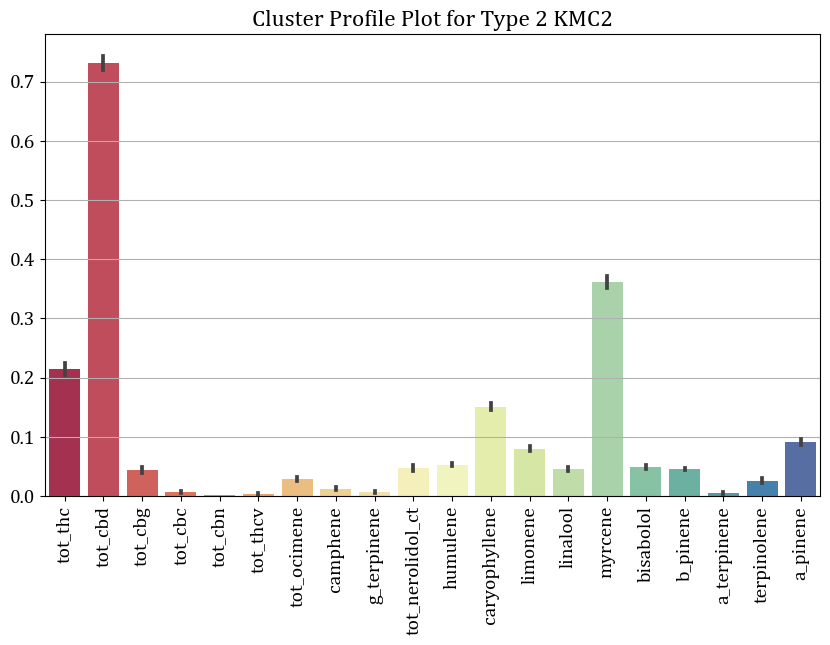

In [53]:
#@title Plot (KMC2) Cluster 2
sns.barplot(data=kmc2_cluster_2, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 2 KMC2')

In [54]:
#@title Cluster 2 Statistics
kmc2_cluster_2.loc['mean'] = kmc2_cluster_2.mean()
#Cluster_2.loc['mean']
kmc2_cluster_2.loc['std'] = kmc2_cluster_2.std()
kmc2_cluster_2.loc[['mean','std']]

tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.214061  0.731220  0.043163  0.007034  0.001242  0.003281     0.028098   
std   0.185135  0.206884  0.097689  0.021288  0.005706  0.042674     0.052420   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.012578     0.006226          0.046596  0.053060       0.150433   
std   0.032925     0.030150          0.085966  0.037948       0.098815   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.079685  0.045937  0.361447   0.049094  0.045416     0.004848   
std   0.066432  0.052951  0.191410   0.056721  0.030558     0.026119   

      terpinolene  a_pinene  
u_id                         
mean     0.025364  0.091217  
std      0.073450  0.082903

## K-Means: K=4

In [55]:
#@title Plot with K-Means Cluster
# sns.set(style = "white")
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='kmc4_assignments', palette='hls', marker='o')
ax.set_title('K-Means; k=4')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for i in range(4):
    flag = np.where(labels_4 == i)[0]
    plt.figure()
    ax = sns.scatterplot(x=clean_lowD_60[flag, 0],y=clean_lowD_60[flag, 1], marker='o')
    ax.set_title('K-Means Cluster {}; k=4'.format(i+1))
    plt.grid()
    plt.show()

ValueError: Could not interpret value `kmc4_assignments` for parameter `hue`

In [66]:
#@title Generate Cluster Profiles
kmc4_cluster_1 = clean_data_values_db.loc[clean_data_values_db['KM4 Classes']==0]
kmc4_cluster_1 = kmc4_cluster_1.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc4_cluster_2 = clean_data_values_db.loc[clean_data_values_db['KM4 Classes']==1]
kmc4_cluster_2 = kmc4_cluster_2.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc4_cluster_3 = clean_data_values_db.loc[clean_data_values_db['KM4 Classes']==2]
kmc4_cluster_3 = kmc4_cluster_3.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc4_cluster_4 = clean_data_values_db.loc[clean_data_values_db['KM4 Classes']==3]
kmc4_cluster_4 = kmc4_cluster_4.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

Text(0.5, 1.0, 'Cluster Profile Plot for Type 1 KMC4')

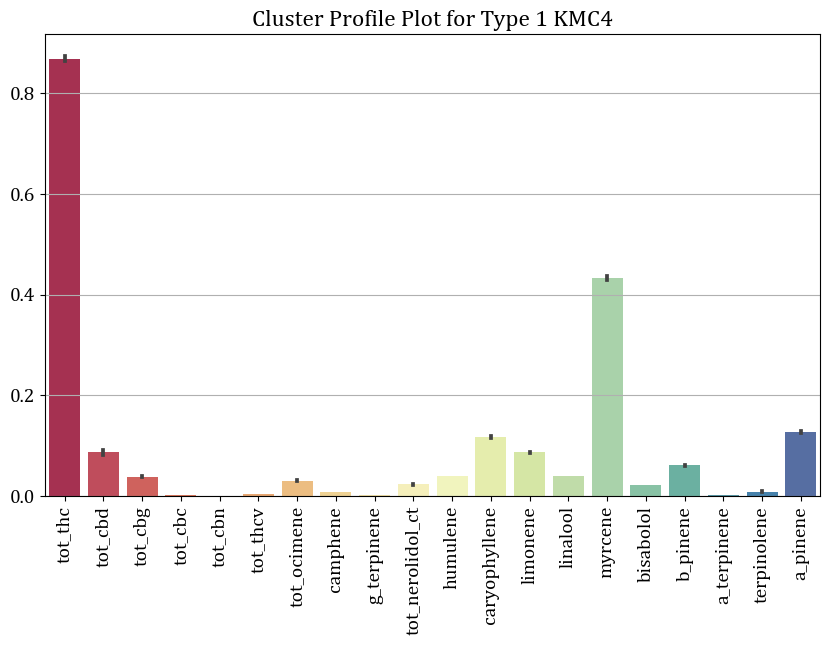

In [67]:
#@title Plot (KMC4) Cluster 1
sns.barplot(data=kmc4_cluster_1, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 1 KMC4')

In [68]:
#@title Cluster 1 (KMC 4) Statistics
kmc4_cluster_1.loc['mean'] = kmc4_cluster_1.mean()
#Cluster_1.loc['mean']
kmc4_cluster_1.loc['std'] = kmc4_cluster_1.std()
print(len(kmc4_cluster_1))
kmc4_cluster_1.loc[['mean','std']]

8111


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.868239  0.087186  0.038183  0.002047  0.000958  0.003388     0.030559   
std   0.244851  0.244123  0.025544  0.008692  0.003076  0.013810     0.043229   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.007989     0.001691          0.023302  0.039927       0.117129   
std   0.007838     0.004091          0.035341  0.024953       0.063302   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.086871  0.039794  0.432918   0.021546  0.061509     0.001466   
std   0.069861  0.028249  0.152461   0.024424  0.040079     0.006112   

      terpinolene  a_pinene  
u_id                         
mean     0.008690  0.126608  
std      0.027281  0.100674

Text(0.5, 1.0, 'Cluster Profile Plot for Type 2 KMC4')

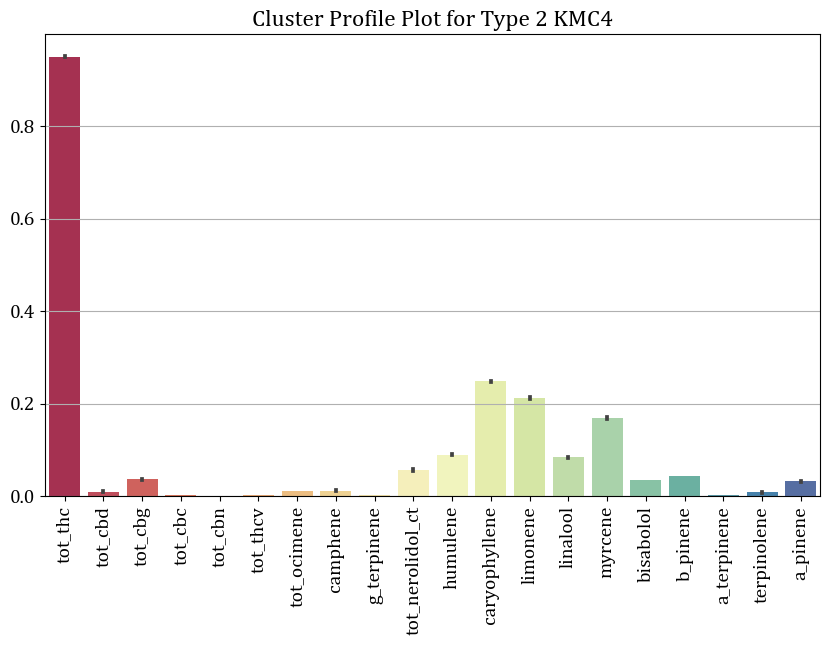

In [69]:
#@title Plot (KMC4) Cluster 2
sns.barplot(data=kmc4_cluster_2, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 2 KMC4')

In [70]:
#@title Cluster 1 Statistics
kmc4_cluster_2.loc['mean'] = kmc4_cluster_2.mean()
#Cluster_1.loc['mean']
kmc4_cluster_2.loc['std'] = kmc4_cluster_2.std()
print(len(kmc4_cluster_2))
kmc4_cluster_2.loc[['mean','std']]

14177


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.950218  0.009747  0.035848  0.001478  0.000832  0.001876     0.010288   
std   0.070201  0.066797  0.019383  0.003648  0.002614  0.005367     0.023417   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.011931     0.002381          0.056339  0.088946       0.247730   
std   0.012996     0.010938          0.077504  0.050755       0.107817   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.211312  0.084015  0.169206   0.034226  0.042958     0.001413   
std   0.110225  0.069451  0.109966   0.034702  0.024157     0.005336   

      terpinolene  a_pinene  
u_id                         
mean     0.007658  0.031595  
std      0.015838  0.025594

Text(0.5, 1.0, 'Cluster Profile Plot for Type 3 KMC4')

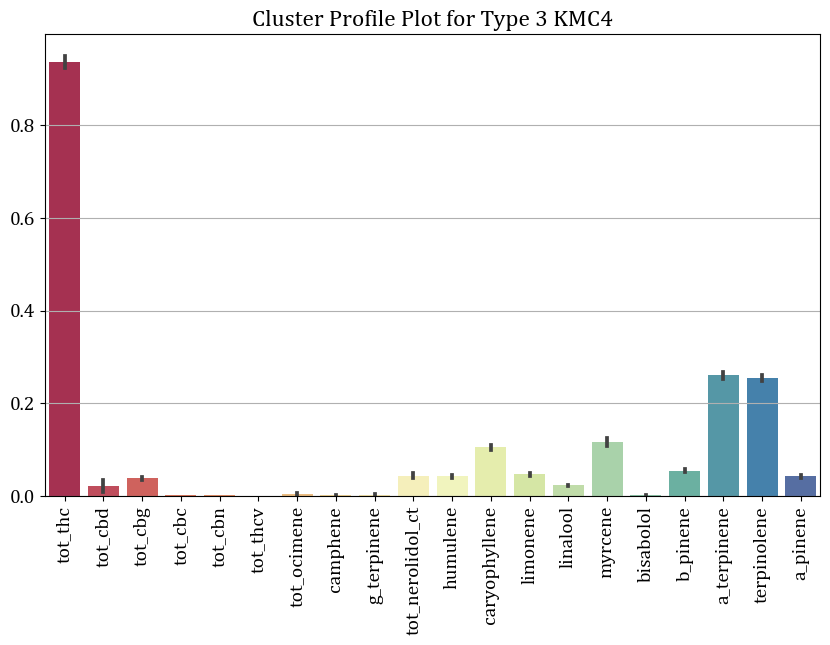

In [71]:
#@title Plot (KMC4) Cluster 3
sns.barplot(data=kmc4_cluster_3, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 3 KMC4')

In [72]:
#@title Cluster 3 Statistics
kmc4_cluster_3.loc['mean'] = kmc4_cluster_3.mean()
#Cluster_1.loc['mean']
kmc4_cluster_3.loc['std'] = kmc4_cluster_3.std()
print(len(kmc4_cluster_3))
kmc4_cluster_3.loc[['mean','std']]

301


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.937396  0.020815  0.037946  0.001705  0.001635  0.000502     0.004954   
std   0.115805  0.111484  0.025789  0.005697  0.003930  0.003404     0.019719   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.001582     0.002631          0.044100  0.042211       0.104748   
std   0.013777     0.010501          0.049299  0.023377       0.057684   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.047304  0.022860  0.116378   0.001210  0.054378     0.260296   
std   0.030553  0.015663  0.076628   0.012722  0.031339     0.060385   

      terpinolene  a_pinene  
u_id                         
mean     0.254281  0.043067  
std      0.065591  0.032938

Text(0.5, 1.0, 'Cluster Profile Plot for Type 4 KMC4')

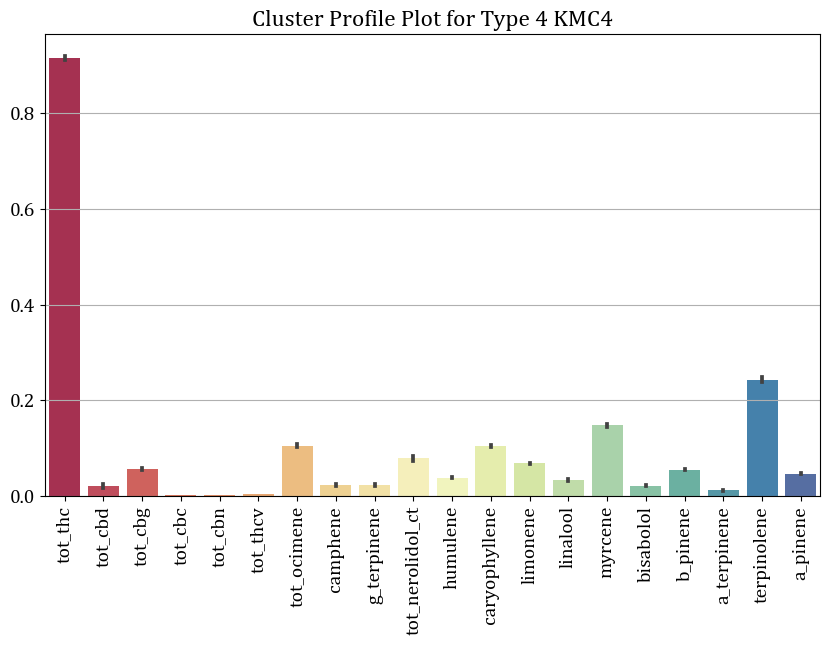

In [73]:
#@title Plot (KMC4) Cluster 4
sns.barplot(data=kmc4_cluster_4, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 4 KMC4')

In [74]:
#@title Cluster 4 Statistics
kmc4_cluster_4.loc['mean'] = kmc4_cluster_4.mean()
#Cluster_4.loc['mean']
kmc4_cluster_4.loc['std'] = kmc4_cluster_4.std()
print(len(kmc4_cluster_4))
kmc4_cluster_4.loc[['mean','std']]

3452


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.915901  0.020873  0.055883  0.001391  0.001850  0.004103     0.105377   
std   0.129663  0.115141  0.062314  0.003477  0.004758  0.022815     0.105966   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.022295     0.023508          0.078705  0.038168       0.105131   
std   0.061368     0.054259          0.160623  0.028842       0.074782   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.068139  0.033037  0.147839   0.021231  0.054604     0.011849   
std   0.046027  0.057923  0.086294   0.030921  0.033539     0.012012   

      terpinolene  a_pinene  
u_id                         
mean     0.243549  0.046569  
std      0.157233  0.041796

## K-Means: K=6

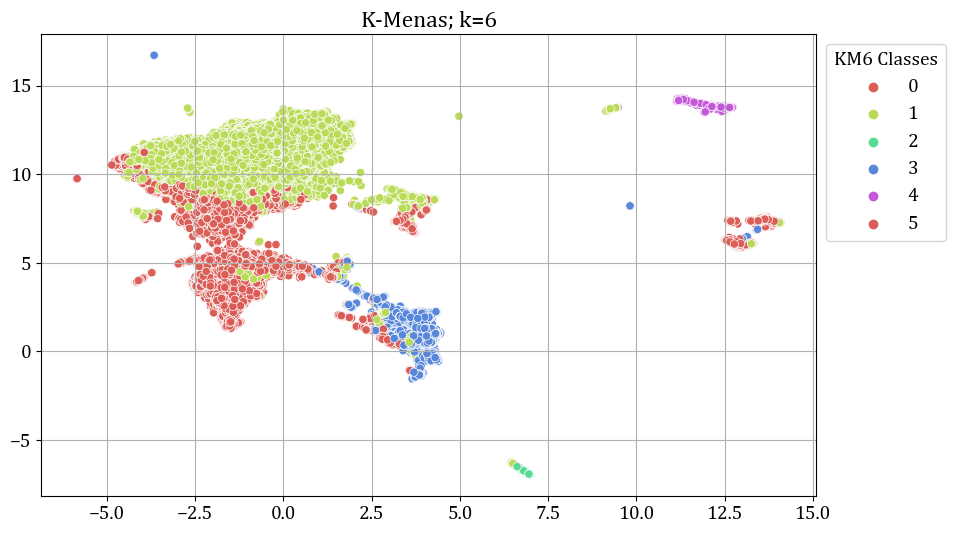

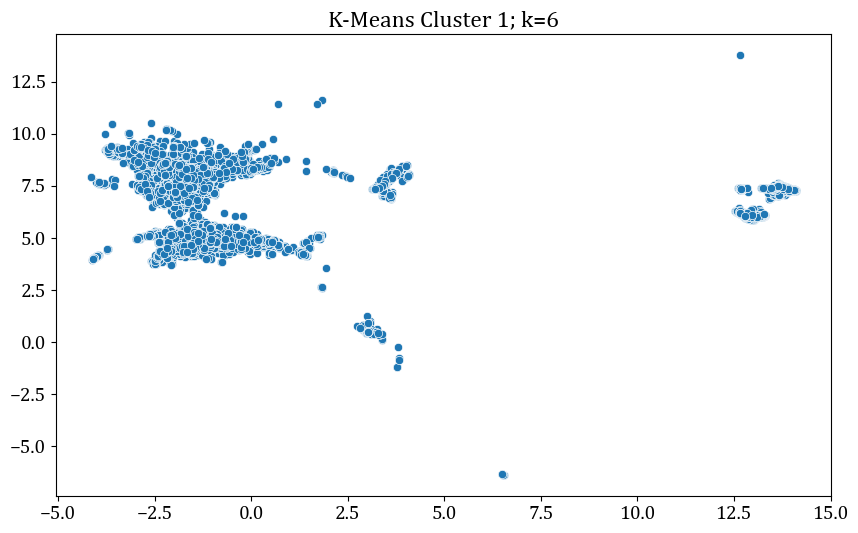

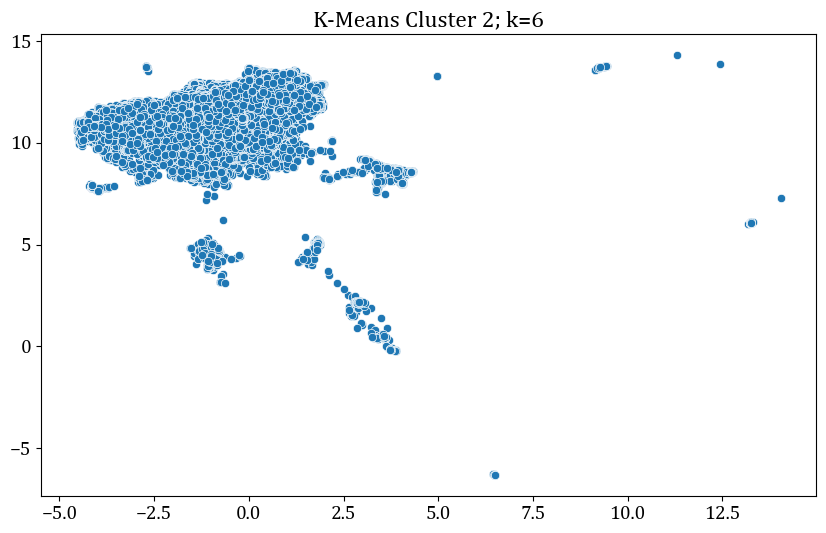

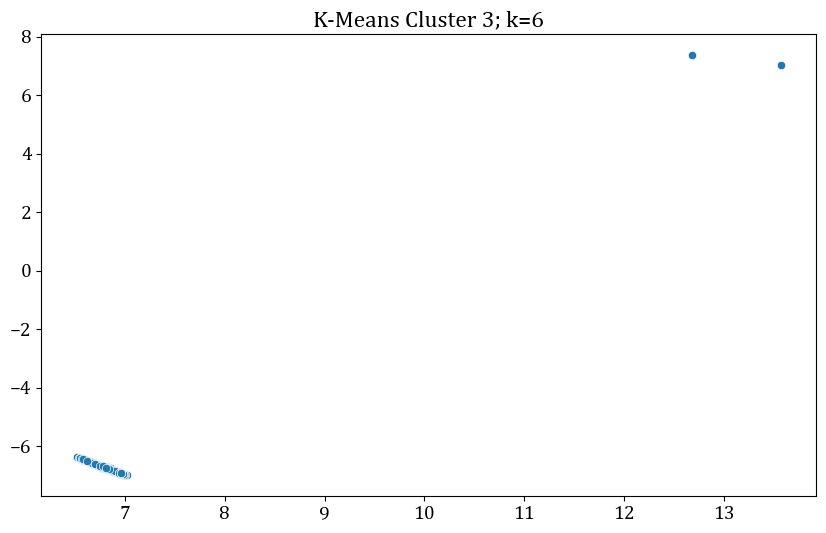

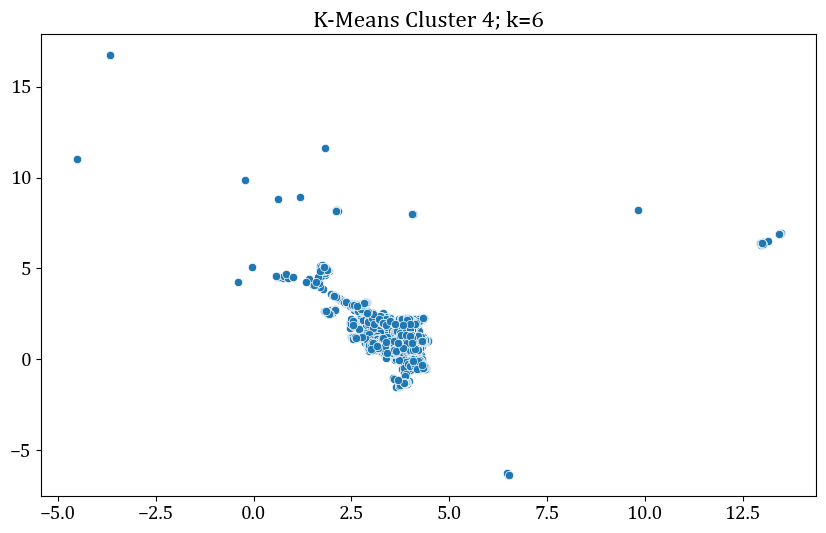

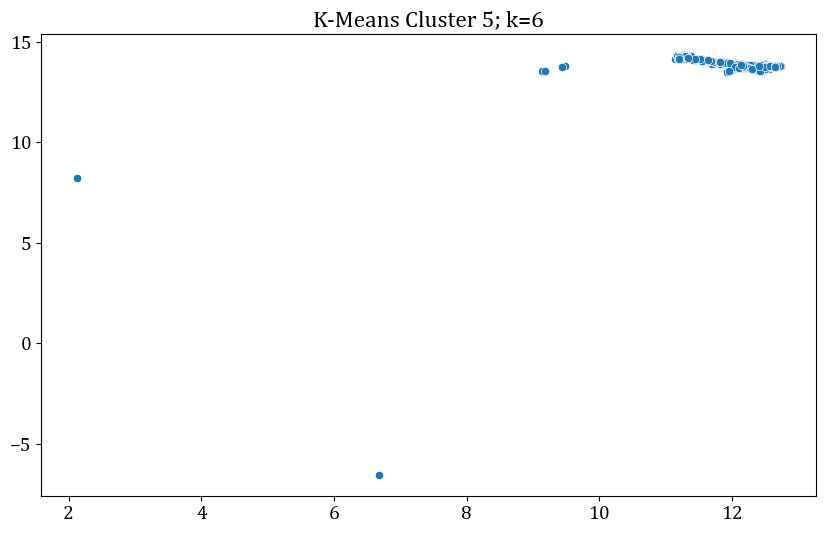

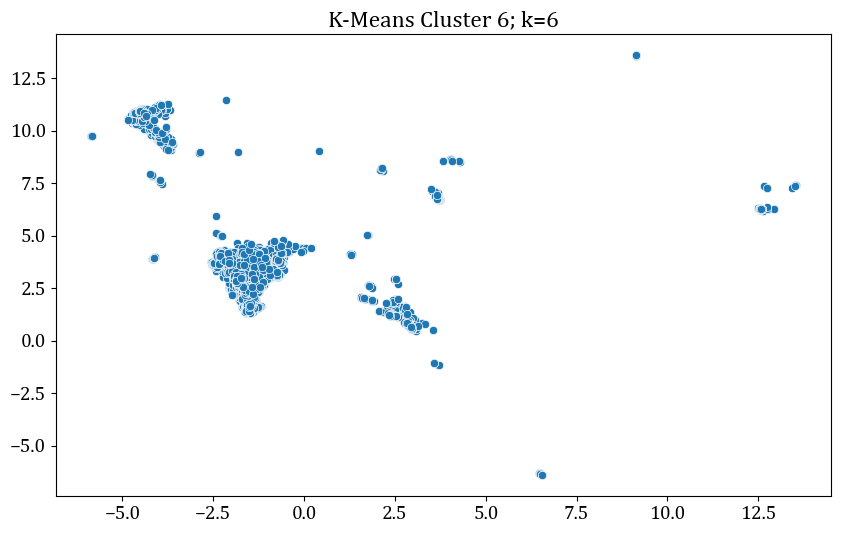

In [76]:
#@title Plot with K-Means Cluster
# sns.set(style = "white")
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='KM6 Classes', palette='hls', marker='o')
ax.set_title('K-Menas; k=6')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for i in range(6):
    flag = np.where(labels_6 == i)[0]
    plt.figure()
    ax = sns.scatterplot(x=clean_lowD_60[flag, 0],y=clean_lowD_60[flag, 1], marker='o')
    ax.set_title('K-Means Cluster {}; k=6'.format(i+1))
    plt.grid()
    plt.show()

In [77]:
#@title Generate Cluster Profiles
kmc6_cluster_1 = clean_data_values_db.loc[clean_data_values_db['KM6 Classes']==0]
kmc6_cluster_1 = kmc6_cluster_1.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc6_cluster_2 = clean_data_values_db.loc[clean_data_values_db['KM6 Classes']==1]
kmc6_cluster_2 = kmc6_cluster_2.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc6_cluster_3 = clean_data_values_db.loc[clean_data_values_db['KM6 Classes']==2]
kmc6_cluster_3 = kmc6_cluster_3.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc6_cluster_4 = clean_data_values_db.loc[clean_data_values_db['KM6 Classes']==3]
kmc6_cluster_4 = kmc6_cluster_4.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc6_cluster_5 = clean_data_values_db.loc[clean_data_values_db['KM6 Classes']==4]
kmc6_cluster_5 = kmc6_cluster_5.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc6_cluster_6 = clean_data_values_db.loc[clean_data_values_db['KM6 Classes']==5]
kmc6_cluster_6 = kmc6_cluster_6.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

Text(0.5, 1.0, 'Cluster Profile Plot for Type 1 KMC6')

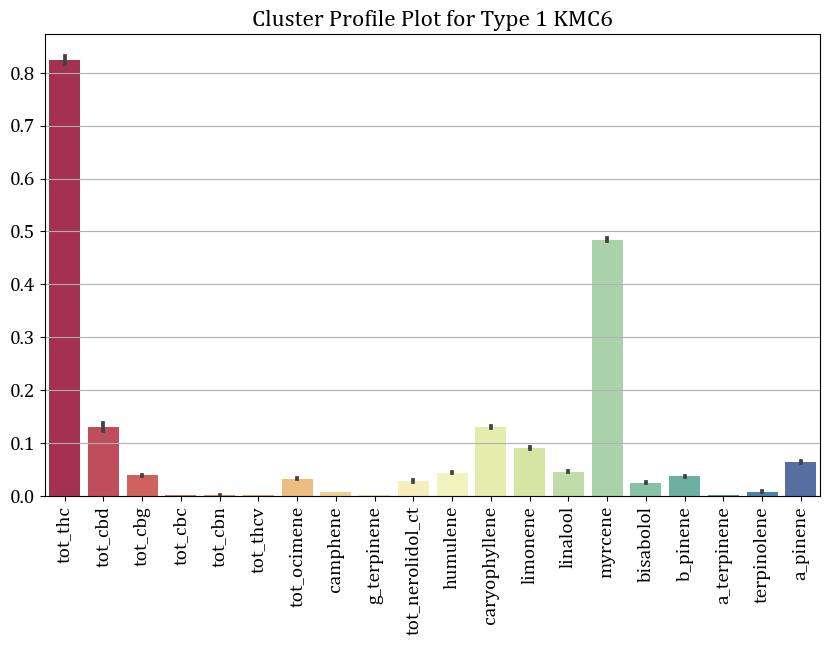

In [78]:
#@title Plot (KMC6) Cluster 1
sns.barplot(data=kmc6_cluster_1, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 1 KMC6')

In [79]:
#@title Cluster VI Statistics
kmc6_cluster_1.loc['mean'] = kmc6_cluster_1.mean()
#Cluster_6.loc['mean']
kmc6_cluster_1.loc['std'] = kmc6_cluster_1.std()
print(len(kmc6_cluster_1))
kmc6_cluster_1.loc[['mean','std']]

5791


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.824316  0.130777  0.038909  0.002455  0.001022  0.002521     0.032493   
std   0.291169  0.291706  0.025637  0.009311  0.003183  0.005871     0.046116   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.006904     0.001433          0.028465  0.044190       0.129779   
std   0.007445     0.003743          0.043143  0.027025       0.069042   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.090059  0.045631  0.484702   0.025464  0.037123     0.001254   
std   0.068191  0.032877  0.126211   0.029660  0.019160     0.005380   

      terpinolene  a_pinene  
u_id                         
mean     0.008109  0.064394  
std      0.027226  0.053551

Text(0.5, 1.0, 'Cluster Profile Plot for Type 2 KMC6')

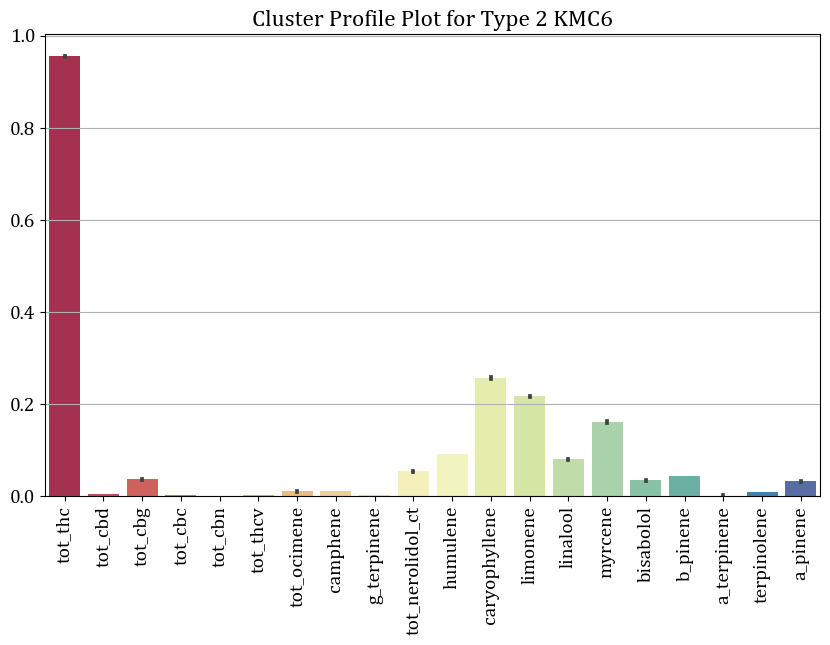

In [80]:
#@title Plot (KMC6) Cluster 2
sns.barplot(data=kmc6_cluster_2, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 2 KMC6')

In [81]:
#@title Cluster 2 (KM6) Statistics
kmc6_cluster_2.loc['mean'] = kmc6_cluster_2.mean()
#Cluster_1.loc['mean']
kmc6_cluster_2.loc['std'] = kmc6_cluster_2.std()
print(len(kmc6_cluster_2))
kmc6_cluster_2.loc[['mean','std']]

13146


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.955216  0.004480  0.036116  0.001452  0.000820  0.001915     0.010079   
std   0.032075  0.024192  0.019144  0.003419  0.002568  0.005530     0.023518   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.011143     0.001584          0.054253  0.091446       0.255800   
std   0.008426     0.006253          0.071367  0.049688       0.103996   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.216306  0.079774  0.161137   0.034183  0.043340     0.001144   
std   0.106626  0.048578  0.099181   0.033312  0.021531     0.004575   

      terpinolene  a_pinene  
u_id                         
mean     0.007959  0.031852  
std      0.016381  0.023854

Text(0.5, 1.0, 'Cluster Profile Plot for Type 3 KMC6')

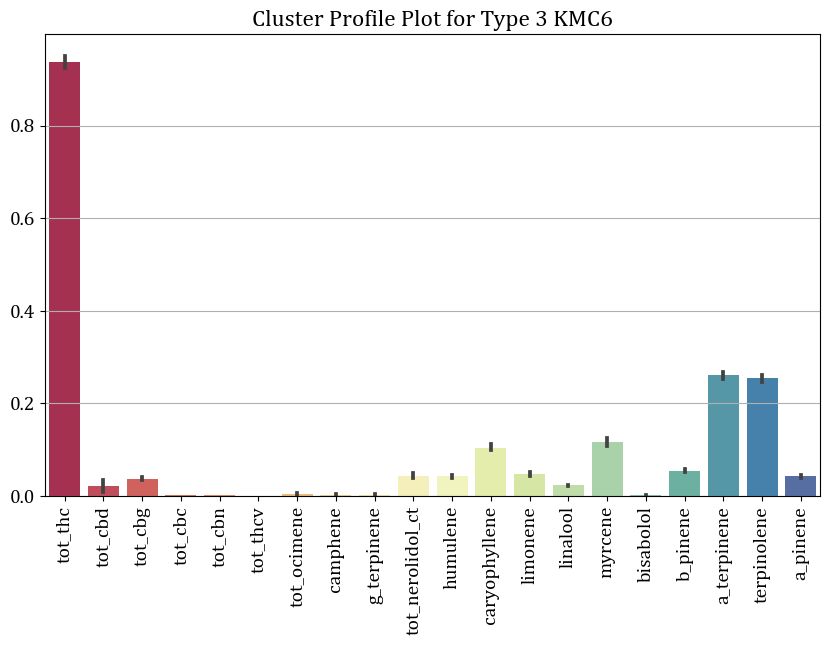

In [82]:
#@title Plot (KMC6) Cluster 3
sns.barplot(data=kmc6_cluster_3, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 3 KMC6')

In [83]:
#@title Cluster III Statistics
kmc6_cluster_3.loc['mean'] = kmc6_cluster_3.mean()
#Cluster_1.loc['mean']
kmc6_cluster_3.loc['std'] = kmc6_cluster_3.std()
print(len(kmc6_cluster_3))
kmc6_cluster_3.loc[['mean','std']]

300


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.937579  0.020877  0.037687  0.001711  0.001641  0.000504     0.004971   
std   0.115956  0.111665  0.025444  0.005706  0.003936  0.003410     0.019750   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.001587     0.002640          0.043914  0.042241       0.104710   
std   0.013800     0.010518          0.049277  0.023410       0.057777   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.047352  0.022936  0.115878   0.001214  0.054301     0.260724   
std   0.030594  0.015634  0.076270   0.012743  0.031363     0.060031   

      terpinolene  a_pinene  
u_id                         
mean      0.25469  0.042841  
std       0.06532  0.032760

Text(0.5, 1.0, 'Cluster Profile Plot for Type 4 KMC6')

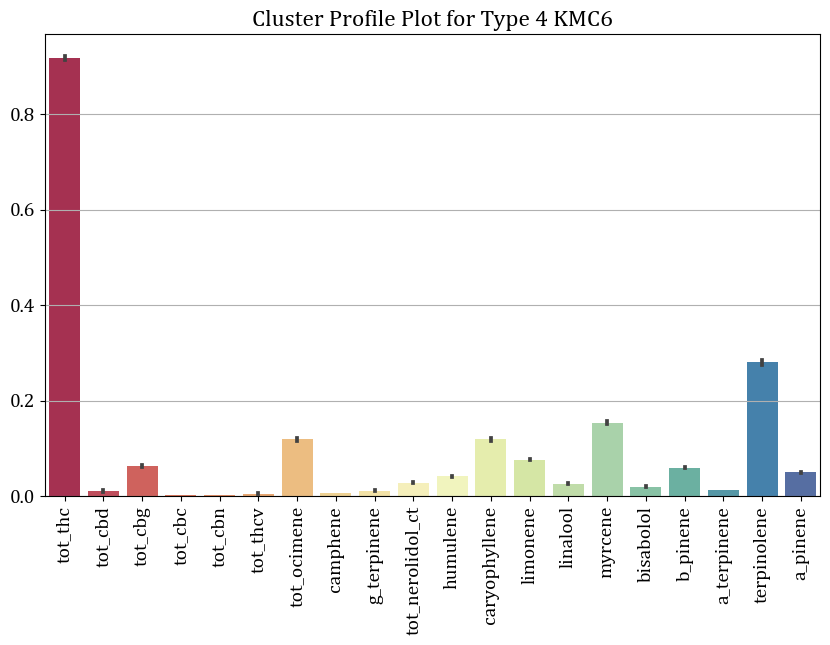

In [84]:
#@title Plot (KMC6) Cluster 4
sns.barplot(data=kmc6_cluster_4, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 4 KMC6')

In [85]:
#@title Cluster 1 Statistics
kmc6_cluster_4.loc['mean'] = kmc6_cluster_4.mean()
#Cluster_1.loc['mean']
kmc6_cluster_4.loc['std'] = kmc6_cluster_4.std()
print(len(kmc6_cluster_4))
kmc6_cluster_4.loc[['mean','std']]

2941


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.917800  0.011065  0.062669  0.001466  0.001978  0.005022     0.118558   
std   0.101175  0.072819  0.064387  0.003706  0.004963  0.030048     0.106671   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.005780     0.011445          0.027948  0.041823       0.118668   
std   0.007401     0.007960          0.040029  0.027487       0.070073   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.076472  0.025733  0.153629   0.019017  0.059563     0.012148   
std   0.039795  0.021480  0.089492   0.023924  0.025423     0.009492   

      terpinolene  a_pinene  
u_id                         
mean     0.279861  0.049355  
std      0.137733  0.033100

Text(0.5, 1.0, 'Cluster Profile Plot for Type 5 KMC6')

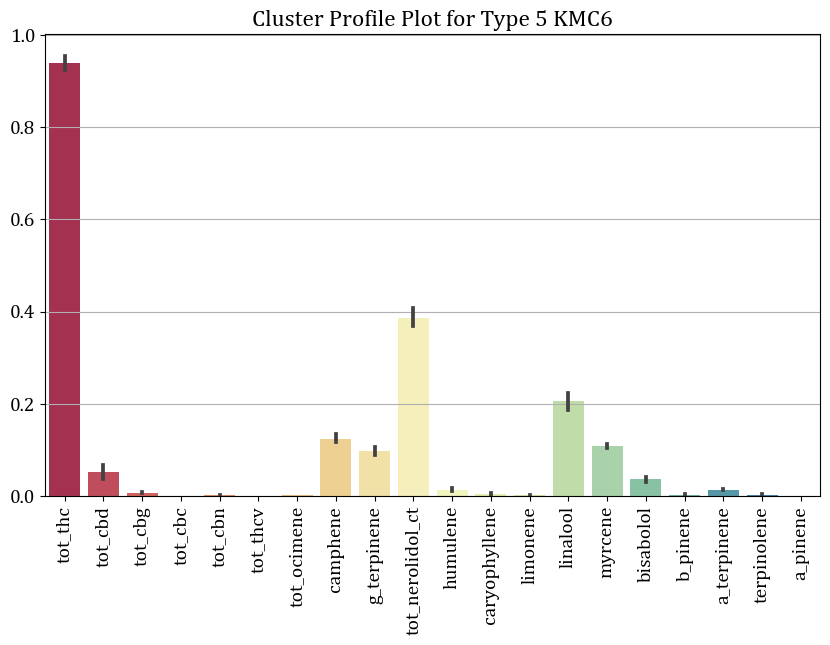

In [86]:
#@title Plot (KMC6) Cluster 5
sns.barplot(data=kmc6_cluster_5, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 5 KMC6')

In [87]:
#@title Cluster 1 Statistics
kmc6_cluster_5.loc['mean'] = kmc6_cluster_5.mean()
#Cluster_1.loc['mean']
kmc6_cluster_5.loc['std'] = kmc6_cluster_5.std()
print(len(kmc6_cluster_5))
kmc6_cluster_5.loc[['mean','std']]

592


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.938430  0.051657  0.007183  0.000867  0.001361  0.000502     0.002153   
std   0.195071  0.194050  0.010276  0.001371  0.004023  0.001064     0.010176   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.124725     0.096718          0.386605  0.014008       0.003611   
std   0.108650     0.109596          0.237539  0.046032       0.028340   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.001276  0.206033  0.108678   0.036078  0.002381     0.014144   
std   0.012119  0.245224  0.054833   0.058945  0.010175     0.021433   

      terpinolene  a_pinene  
u_id                         
mean     0.003305  0.000285  
std      0.014013  0.003418

Text(0.5, 1.0, 'Cluster Profile Plot for Type 6 KMC6')

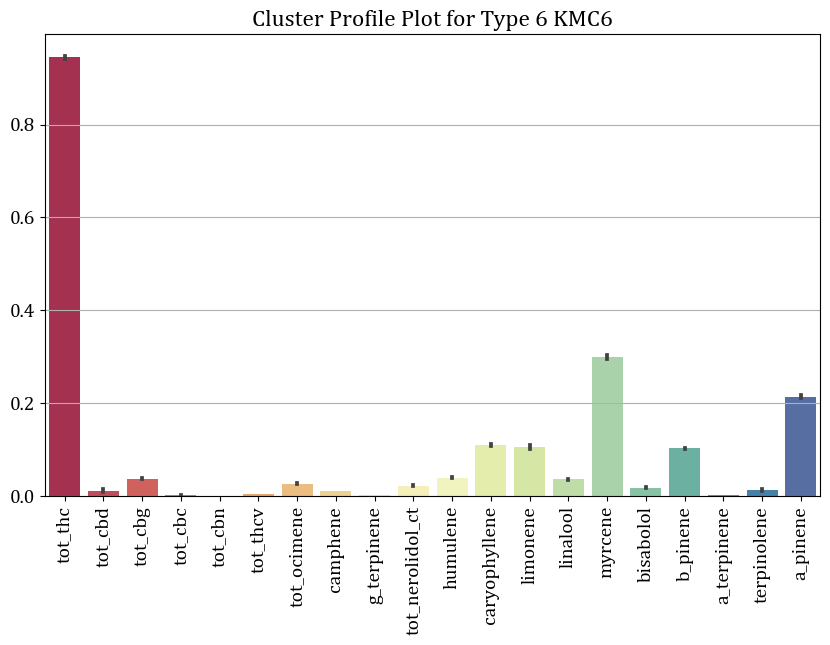

In [88]:
#@title Plot (KMC6) Cluster 6
sns.barplot(data=kmc6_cluster_6, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 6 KMC6')

In [89]:
#@title Cluster 6 Statistics
kmc6_cluster_5.loc['mean'] = kmc6_cluster_5.mean()
#Cluster_1.loc['mean']
kmc6_cluster_5.loc['std'] = kmc6_cluster_5.std()
print(len(kmc6_cluster_5))
kmc6_cluster_5.loc[['mean','std']]

592


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.937174  0.051897  0.007188  0.000868  0.001365  0.000503     0.002166   
std   0.197286  0.193974  0.010268  0.001370  0.004021  0.001063     0.010173   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.124698     0.096740          0.386353  0.014062       0.003653   
std   0.108560     0.109504          0.237417  0.046012       0.028335   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.001294  0.206099  0.108587   0.036117  0.002395     0.014156   
std   0.012117  0.245021  0.054831   0.058902  0.010171     0.021417   

      terpinolene  a_pinene  
u_id                         
mean     0.003323  0.000291  
std      0.014008  0.003417

## K-Means: K=8

In [ ]:
#@title Plot with K-Means Cluster
# sns.set(style = "white")
ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=clean_data_values_db, hue='KM8 Classes', palette='hls', marker='o')
ax.set_title('K-Means; k=8')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for i in range(8):
    flag = np.where(labels_8 == i)[0]
    plt.figure()
    ax = sns.scatterplot(x=clean_lowD_60[flag, 0],y=clean_lowD_60[flag, 1], marker='o')
    ax.set_title('K-Means Cluster {}; k=8'.format(i+1))
    plt.grid()
    plt.show()

In [90]:
#@title Generate Cluster Profiles
kmc8_cluster_1 = clean_data_values_db.loc[clean_data_values_db['KM8 Classes']==0]
kmc8_cluster_1 = kmc8_cluster_1.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc8_cluster_2 = clean_data_values_db.loc[clean_data_values_db['KM8 Classes']==1]
kmc8_cluster_2 = kmc8_cluster_2.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc8_cluster_3 = clean_data_values_db.loc[clean_data_values_db['KM8 Classes']==2]
kmc8_cluster_3 = kmc8_cluster_3.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc8_cluster_4 = clean_data_values_db.loc[clean_data_values_db['KM8 Classes']==3]
kmc8_cluster_4 = kmc8_cluster_4.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc8_cluster_5 = clean_data_values_db.loc[clean_data_values_db['KM8 Classes']==4]
kmc8_cluster_5 = kmc8_cluster_5.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc8_cluster_6 = clean_data_values_db.loc[clean_data_values_db['KM8 Classes']==5]
kmc8_cluster_6 = kmc8_cluster_6.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc8_cluster_7 = clean_data_values_db.loc[clean_data_values_db['KM8 Classes']==6]
kmc8_cluster_7 = kmc8_cluster_7.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

kmc8_cluster_8 = clean_data_values_db.loc[clean_data_values_db['KM8 Classes']==7]
kmc8_cluster_8 = kmc8_cluster_8.drop(columns = ['assignments', 'KM2 Classes', 'KM4 Classes', 'KM6 Classes', 'KM8 Classes'])

Text(0.5, 1.0, 'Cluster Profile Plot for Type 1 KMC8')

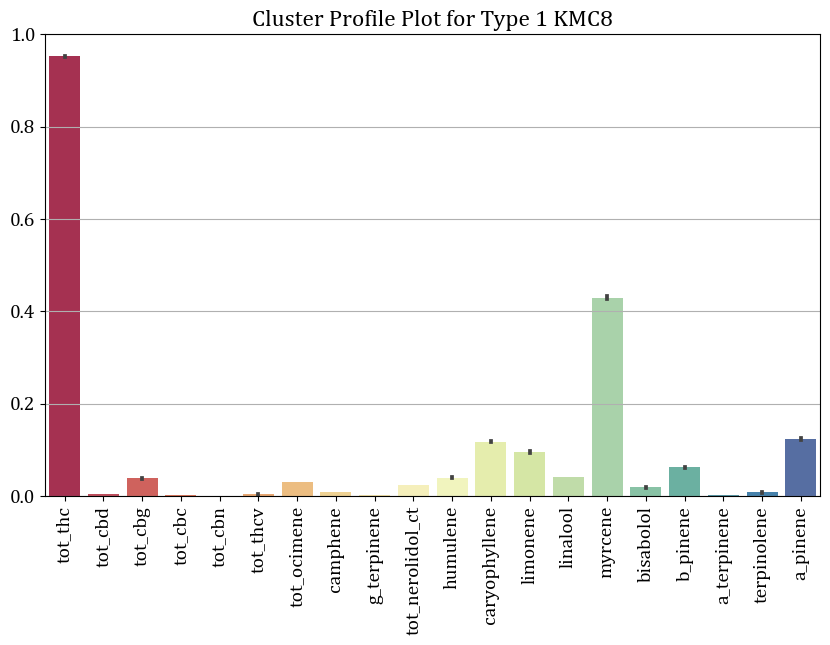

In [91]:
#@title Plot (KMC8) Cluster 1
sns.barplot(data=kmc8_cluster_1, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 1 KMC8')

In [92]:
#@title Cluster 1 Statistics
kmc8_cluster_1.loc['mean'] = kmc8_cluster_1.mean()
#Cluster_1.loc['mean']
kmc8_cluster_1.loc['std'] = kmc8_cluster_1.std()
print(len(kmc8_cluster_1))
kmc8_cluster_1.loc[['mean','std']]

7731


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.951983  0.004180  0.038213  0.001279  0.000905  0.003440      0.03024   
std   0.030762  0.017376  0.022958  0.003258  0.002813  0.009336      0.04255   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.008175     0.001671          0.023661  0.039875       0.117647   
std   0.007704     0.004057          0.036205  0.024179       0.061497   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.095363  0.041530  0.429063   0.018647  0.061909     0.001425   
std   0.079225  0.029218  0.149750   0.018436  0.040089     0.005973   

      terpinolene  a_pinene  
u_id                         
mean     0.008102  0.122693  
std      0.025011  0.101593

Text(0.5, 1.0, 'Cluster Profile Plot for Type 2 KMC8')

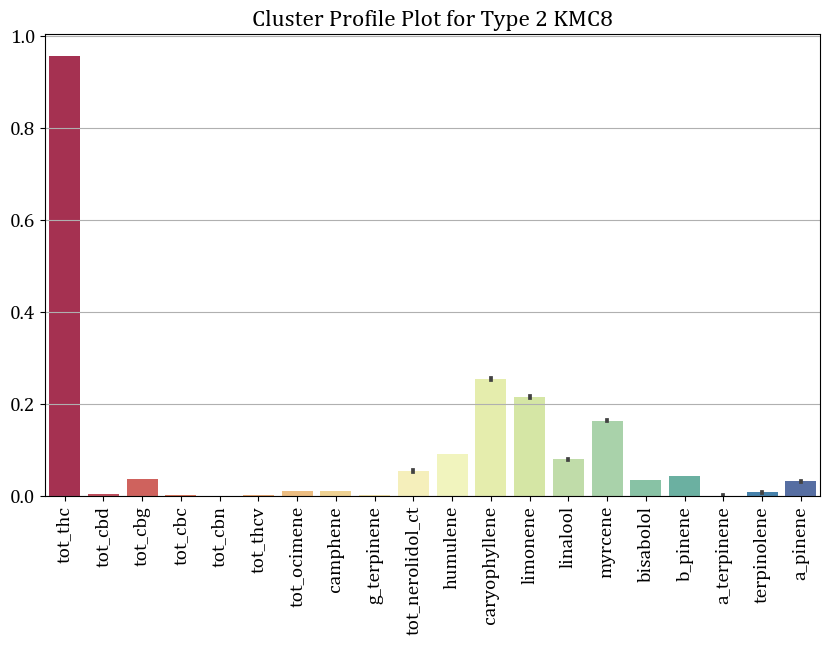

In [93]:
#@title Plot (KMC8) Cluster 2
sns.barplot(data=kmc8_cluster_2, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 2 KMC8')

In [94]:
#@title Cluster 1 Statistics
kmc8_cluster_2.loc['mean'] = kmc8_cluster_2.mean()
#Cluster_1.loc['mean']
kmc8_cluster_2.loc['std'] = kmc8_cluster_2.std()
print(len(kmc8_cluster_2))
kmc8_cluster_2.loc[['mean','std']]

13368


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.955701  0.003796  0.036289  0.001501  0.000841  0.001872     0.010360   
std   0.025009  0.013404  0.019296  0.003681  0.002613  0.005401     0.023967   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.011065     0.001635          0.054405  0.091156       0.254218   
std   0.008402     0.006712          0.071158  0.049903       0.103977   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.215283  0.079570  0.163782   0.034471  0.043392     0.001118   
std   0.108014  0.048407  0.104305   0.033675  0.023565     0.004486   

      terpinolene  a_pinene  
u_id                         
mean     0.007839  0.031706  
std      0.016189  0.024889

Text(0.5, 1.0, 'Cluster Profile Plot for Type 3 KMC8')

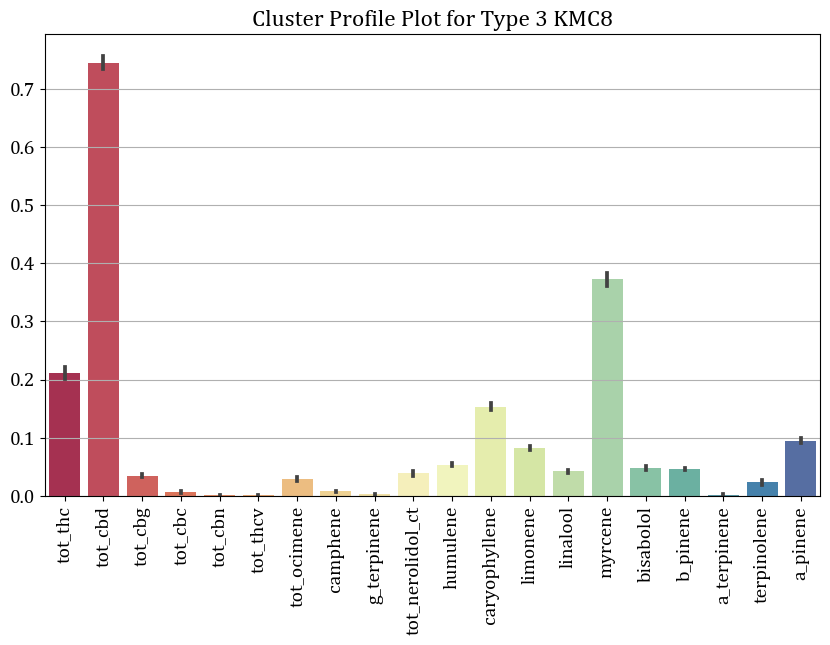

In [95]:
#@title Plot (KMC8) Cluster 3
sns.barplot(data=kmc8_cluster_3, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 3 KMC8')

In [96]:
#@title Cluster 1 Statistics
kmc8_cluster_3.loc['mean'] = kmc8_cluster_3.mean()
#Cluster_1.loc['mean']
kmc8_cluster_3.loc['std'] = kmc8_cluster_3.std()
print(len(kmc8_cluster_3))
kmc8_cluster_3.loc[['mean','std']]

1075


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.211298  0.744217  0.035147  0.007192  0.001077  0.001069     0.029101   
std   0.181141  0.189056  0.035783  0.021747  0.004151  0.003005     0.053548   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.008238     0.002634          0.039128  0.053933       0.153230   
std   0.012103     0.008097          0.069472  0.037555       0.096032   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.082364  0.042418  0.372193   0.048391  0.046996     0.002599   
std   0.066592  0.037245  0.186234   0.051601  0.030045     0.009632   

      terpinolene  a_pinene  
u_id                         
mean     0.023619  0.095157  
std      0.069494  0.081561

Text(0.5, 1.0, 'Cluster Profile Plot for Type 4 KMC8')

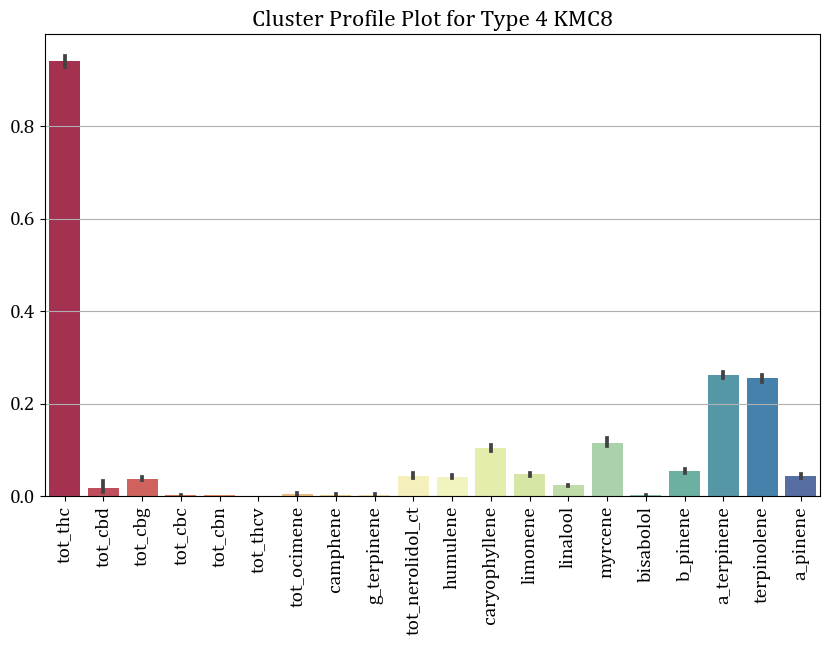

In [97]:
#@title Plot (KMC8) Cluster 4
sns.barplot(data=kmc8_cluster_4, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 4 KMC8')

In [98]:
#@title Cluster 1 Statistics
kmc8_cluster_4.loc['mean'] = kmc8_cluster_4.mean()
#Cluster_1.loc['mean']
kmc8_cluster_4.loc['std'] = kmc8_cluster_4.std()
print(len(kmc8_cluster_4))
kmc8_cluster_4.loc[['mean','std']]

299


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.940469  0.017973  0.037730  0.001676  0.001647  0.000506     0.004987   
std   0.104898  0.099992  0.025476  0.005682  0.003941  0.003415     0.019781   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.001593     0.002649          0.044001  0.042181       0.104576   
std   0.013823     0.010534          0.049337  0.023426       0.057828   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.047349  0.022953  0.115437   0.001218  0.054362     0.260973   
std   0.030645  0.015657  0.076017   0.012765  0.031398     0.059978   

      terpinolene  a_pinene  
u_id                         
mean     0.254918  0.042802  
std      0.065311  0.032808

Text(0.5, 1.0, 'Cluster Profile Plot for Type 5 KMC8')

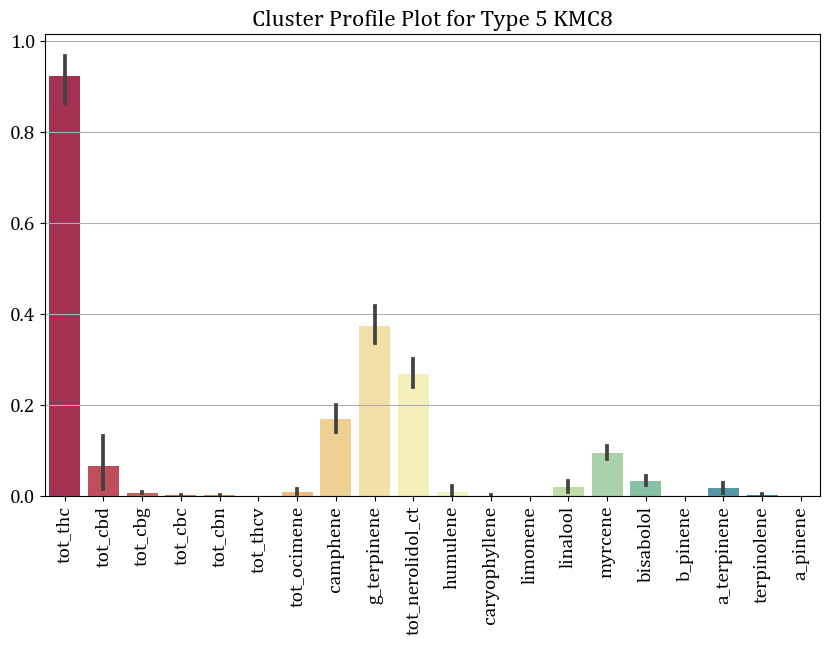

In [99]:
#@title Plot (KMC8) Cluster V
sns.barplot(data=kmc8_cluster_5, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 5 KMC8')

In [100]:
#@title Cluster 1 Statistics
kmc8_cluster_5.loc['mean'] = kmc8_cluster_5.mean()
#Cluster_1.loc['mean']
kmc8_cluster_5.loc['std'] = kmc8_cluster_5.std()
print(len(kmc8_cluster_5))
kmc8_cluster_5.loc[['mean','std']]

53


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.923639  0.065161  0.007551  0.001293  0.001935  0.000422     0.008736   
std   0.197411  0.196215  0.002765  0.001543  0.003970  0.000679     0.019468   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.169403     0.374334          0.268981  0.009495       0.000696   
std   0.108191     0.144567          0.115107  0.035211       0.004922   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.000348  0.018882  0.095160   0.033389       0.0     0.017782   
std   0.002461  0.042733  0.050684   0.035861       0.0     0.041112   

      terpinolene  a_pinene  
u_id                         
mean     0.002446  0.000348  
std      0.008670  0.002461

Text(0.5, 1.0, 'Cluster Profile Plot for Type 6 KMC8')

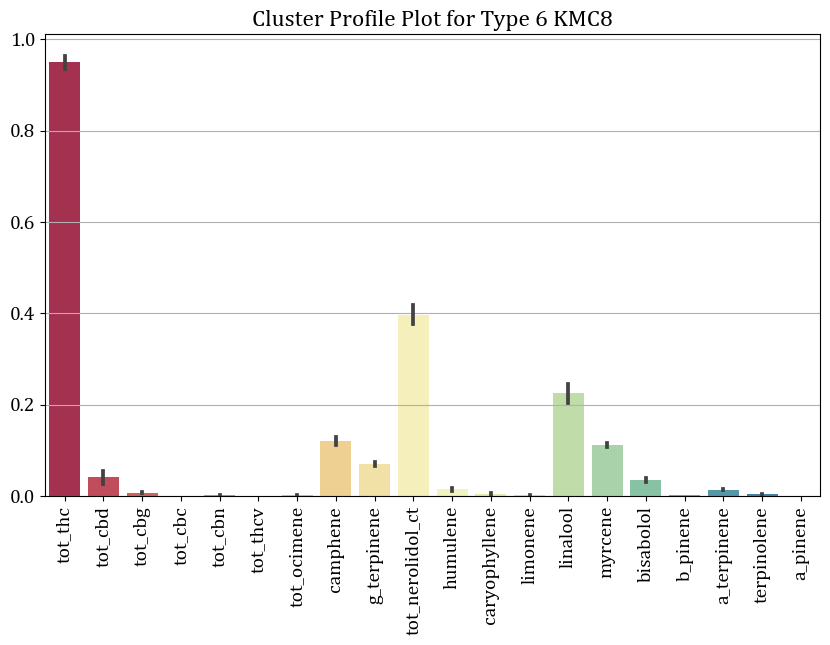

In [101]:
#@title Plot (KMC8) Cluster 6
sns.barplot(data=kmc8_cluster_6, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 6 KMC8')

In [102]:
#@title Cluster 1 Statistics
kmc8_cluster_6.loc['mean'] = kmc8_cluster_6.mean()
#Cluster_1.loc['mean']
kmc8_cluster_6.loc['std'] = kmc8_cluster_6.std()
print(len(kmc8_cluster_6))
kmc8_cluster_6.loc[['mean','std']]

536


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.949534  0.040831  0.007015  0.000796  0.001318  0.000505     0.001506   
std   0.174134  0.173367  0.010501  0.001311  0.004045  0.001097     0.008545   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.120868     0.070295          0.397198  0.014398       0.003541   
std   0.107929     0.056336          0.241340  0.047007       0.027050   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.001320  0.224772  0.110956   0.035306  0.002387     0.013784   
std   0.012542  0.249938  0.054502   0.059609  0.009928     0.018432   

      terpinolene  a_pinene  
u_id                         
mean     0.003386  0.000282  
std      0.014470  0.003511

Text(0.5, 1.0, 'Cluster Profile Plot for Type 7 KMC8')

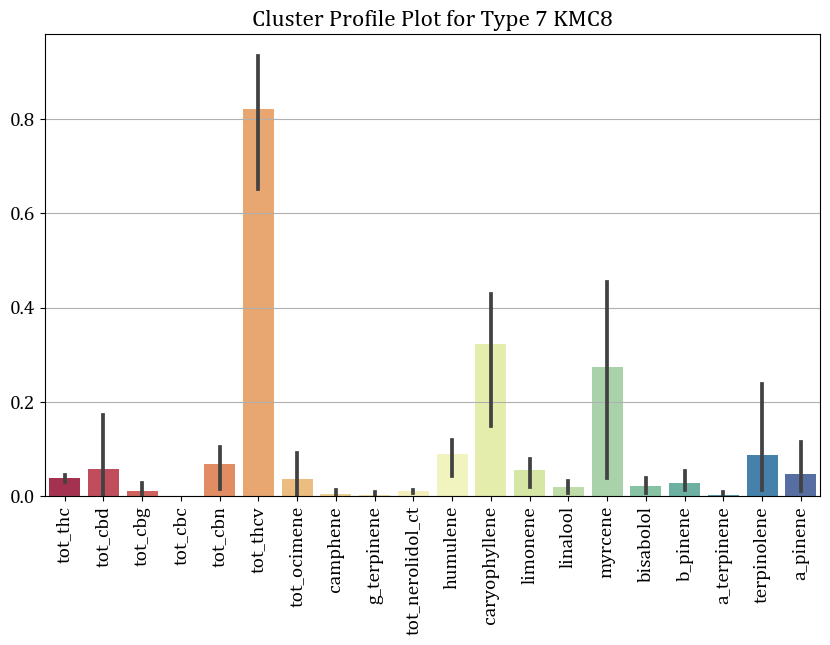

In [103]:
#@title Plot (KMC8) Cluster VII
sns.barplot(data=kmc8_cluster_7, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 7 KMC8')

In [104]:
#@title Cluster 1 Statistics
kmc8_cluster_7.loc['mean'] = kmc8_cluster_7.mean()
#Cluster_1.loc['mean']
kmc8_cluster_7.loc['std'] = kmc8_cluster_7.std()
print(len(kmc8_cluster_7))
kmc8_cluster_7.loc[['mean','std']]

5


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.039266  0.058133  0.011374  0.000543  0.068904  0.821780     0.035134   
std   0.006731  0.081016  0.011130  0.000393  0.038397  0.122019     0.040585   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.004465     0.002516          0.010899  0.088656       0.323069   
std   0.006315     0.003558          0.002546  0.033408       0.124261   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.056298  0.018233  0.274611   0.021724  0.027809     0.002875   
std   0.027057  0.009881  0.174720   0.012471  0.017732     0.004066   

      terpinolene  a_pinene  
u_id                         
mean     0.087739  0.045972  
std      0.106199  0.049338

Text(0.5, 1.0, 'Cluster Profile Plot for Type 8 KMC8')

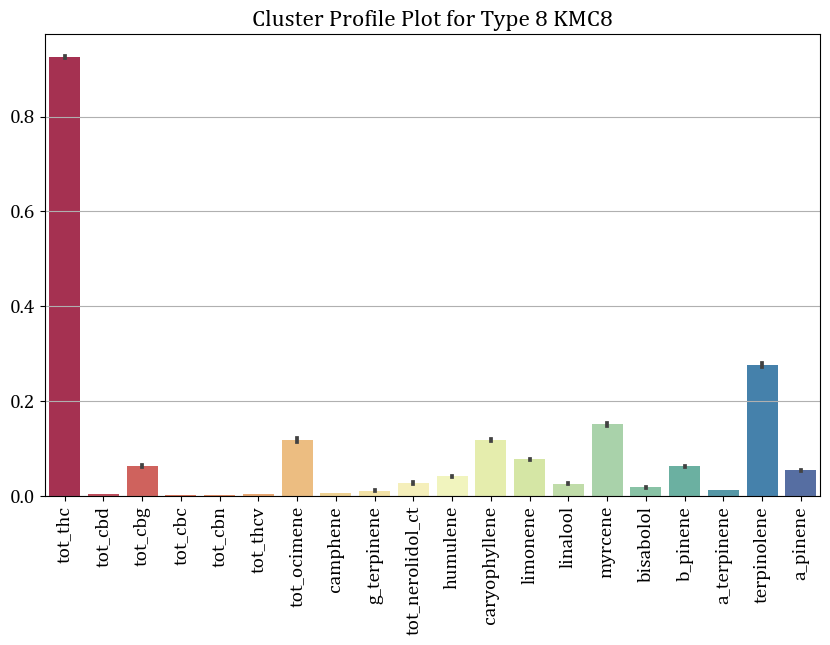

In [105]:
#@title Plot (KMC8) Cluster VIII
sns.barplot(data=kmc8_cluster_8, palette="Spectral")
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 8 KMC8')

In [106]:
#@title Cluster 1 Statistics
kmc8_cluster_8.loc['mean'] = kmc8_cluster_8.mean()
#Cluster_1.loc['mean']
kmc8_cluster_8.loc['std'] = kmc8_cluster_8.std()
print(len(kmc8_cluster_8))
kmc8_cluster_8.loc[['mean','std']]

2982


tot_thc   tot_cbd   tot_cbg   tot_cbc   tot_cbn  tot_thcv  tot_ocimene  \
u_id                                                                            
mean  0.925481  0.003744  0.063238  0.001410  0.001862  0.004266     0.118263   
std   0.067653  0.014475  0.063975  0.003597  0.004226  0.014345     0.105454   

      camphene  g_terpinene  tot_nerolidol_ct  humulene  caryophyllene  \
u_id                                                                     
mean  0.005939     0.011523          0.027288  0.041430       0.117400   
std   0.007383     0.008042          0.039318  0.027454       0.069689   

      limonene  linalool   myrcene  bisabolol  b_pinene  a_terpinene  \
u_id                                                                   
mean  0.077570  0.025677  0.150991   0.018697  0.062400     0.012114   
std   0.040962  0.021466  0.089223   0.023736  0.029966     0.009699   

      terpinolene  a_pinene  
u_id                         
mean     0.276729  0.053980  
std      0.138529  0.043871

# Part IV: Updated Dataframes with Cluster Membership

In [ ]:
#@title Prepare Clean Data for Partitioning
clean_data_clustered = pd.concat([clean_data, clean_data_values_db['assignments']], axis=1)
clean_data_with_noise = clean_data_clustered
clean_data_clustered = clean_data_clustered.loc[clean_data_clustered.assignments >= 0]
clean_data_clustered = clean_data_clustered.drop(['strain_slug', 'region'], axis=1)
clean_data_clustered

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_1 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 0]
Cluster_1 = Cluster_1.drop(columns='assignments')
sns.barplot(data=Cluster_1)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type I')

In [ ]:
#@title Cluster 1 Statistics
Cluster_1.loc['mean'] = Cluster_1.mean()
#Cluster_1.loc['mean']
Cluster_1.loc['std'] = Cluster_1.std()
Cluster_1.loc[['mean','std']]

In [ ]:
print(len(Cluster_1))

In [ ]:
Cluster_1_max_terp = Cluster_1.iloc[:,6:]
Cluster_1_max_terp['max_terp'] = Cluster_1_max_terp.idxmax(axis=1)
Cluster_1_max_terp.head()

In [ ]:
#ax = sns.scatterplot(x = clean_lowD_60[:, 0],y = clean_lowD_60[:, 1], data=Cluster_1_max_terp, hue='max_terp', palette='tab20', marker='o')
#ax.set_title('Clusters')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_2 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 1]
Cluster_2 = Cluster_2.drop(columns='assignments')
sns.barplot(data=Cluster_2)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type II')

In [ ]:
#@title Cluster 2 Statistics
Cluster_2.loc['mean'] = Cluster_2.mean()
#Cluster_1.loc['mean']
Cluster_2.loc['std'] = Cluster_2.std()
Cluster_2.loc[['mean','std']]

In [ ]:
print(len(Cluster_2))

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_3 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 2]
Cluster_3 = Cluster_3.drop(columns='assignments')
sns.barplot(data=Cluster_3)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type III')

In [ ]:
#@title Cluster 3 Statistics
Cluster_3.loc['mean'] = Cluster_3.mean()
#Cluster_1.loc['mean']
Cluster_3.loc['std'] = Cluster_3.std()
Cluster_3.loc[['mean','std']]

In [ ]:
print(len(Cluster_3))

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_4 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 3]
Cluster_4 = Cluster_4.drop(columns='assignments')
sns.barplot(data=Cluster_4)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 4')

In [ ]:
#@title Cluster 3 Statistics
Cluster_4.loc['mean'] = Cluster_4.mean()
#Cluster_1.loc['mean']
Cluster_4.loc['std'] = Cluster_4.std()
Cluster_4.loc[['mean','std']]

In [ ]:
print(len(Cluster_4))

In [ ]:
#@title Create Cluster Subsets for Cluster Statistics
Cluster_5 = clean_data_clustered.loc[clean_data_clustered['assignments'] == 4]
Cluster_5 = Cluster_5.drop(columns='assignments')
sns.barplot(data=Cluster_5)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Type 5')

In [ ]:
#@title Cluster 5 Statistics
Cluster_5.loc['mean'] = Cluster_5.mean()
#Cluster_1.loc['mean']
Cluster_5.loc['std'] = Cluster_5.std()
Cluster_5.loc[['mean','std']]

In [ ]:
print(len(Cluster_5))

In [ ]:
#@title Create Cluster Subsets for Outlier Statistics
Outliers = clean_data_with_noise.loc[clean_data_with_noise['assignments'] == -1]
Outliers = Outliers.drop(columns=['strain_slug','region','assignments'])
sns.barplot(data=Outliers)
plt.xticks(rotation=90)
plt.title('Cluster Profile Plot for Outliers')

In [ ]:
#@title Cluster 3 Statistics
Outliers.loc['mean'] = Outliers.mean()
#Cluster_1.loc['mean']
Outliers.loc['std'] = Outliers.std()
Outliers.loc[['mean','std']]

In [ ]:
print(len(Outliers))